## Imports

In [3]:
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import networkx as nx
import tqdm
import random
import math
import pickle
import torch
from torch import Tensor
import pandas as pd
import torch_geometric
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.utils import to_undirected, is_undirected
import numpy as np
from networkx import to_dict_of_dicts
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, HGTLoader,NeighborSampler
from torch_geometric.utils import mask_select, index_to_mask
from tqdm.auto import tqdm
import pyarrow as pa
import pyarrow.parquet as pq 
import os
import pickle
import pandas as pd
from IPython.display import display, HTML
import json

c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pickle
import pandas as pd
import networkx as nx
import numpy as np
import scipy.sparse as sp
import implicit

In [5]:
print(torch.__version__)

2.2.2+cu118


In [4]:
#init cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load Graph Data
ORiginal Data from their Study

In [5]:
import pickle

# First, extract the contents of dataset.rar to a folder

# Then, load the data from the dataset.pickle file
with open('data/MRecury_data/dataset_typed.pickle', 'rb') as f:
    dataset = pickle.load(f)

# Now you can access the different parts of the dataset:
full_graph = dataset['full']
train_graph = dataset['train']
test_graph = dataset['test']
users_mapping = dataset['users']
user = dataset['users']
#artist_tracks_mapping = dataset['artist-tracks']
# Load New Mapping: 
artist_tracks_mapping = pd.read_csv('data/new_artist_tracks_mapping_df.csv')


# Accessing nodes and edges of the graphs:
full_nodes = full_graph.nodes()
full_edges = full_graph.edges()

train_nodes = train_graph.nodes()
train_edges = train_graph.edges()

test_nodes = test_graph.nodes()
test_edges = test_graph.edges()



In [6]:
def extract_user_song_interactions(g):
    # Lists to store user IDs, track IDs, and scrobbles
    user_ids = []
    track_ids = []
    scrobble_counts = []

    # Iterate over all edges in the graph
    for u, v, attr in g.edges(data=True):
        # User ids range 0-3306
        if u < len(user):
            user_ids.append(u)
            track_ids.append(v)
        else:
            user_ids.append(v)
            track_ids.append(u)
        scrobble_counts.append(attr.get('scrobbles', 0))  # Default scrobbles to 0 if not present

    # Create a DataFrame from the lists
    data = {
        'User ID': user_ids,
        'Track ID': track_ids,
        'Scrobbles': scrobble_counts
    }
    df = pd.DataFrame(data)
    return df


In [7]:
mercury_test_graph = extract_user_song_interactions(test_graph)

# Load Cleaned Graphs Data
The graphs cleaned from the missing Song in the original data (252013 instead of 252014)

In [8]:
test_graph_df = pd.read_csv('data/test_graph_df_clean.csv')
df_test = test_graph_df
df_test = df_test.rename(columns={'User_ID': 'User ID', 'Song_ID': 'Track ID'})
df_test

,User ID,Track ID,Scrobbles,Position,Date,Artist,Song_Name,Artist_ID
0,0,185405,8,130,"Thursday 23 Sep 2021, 9:31am",Phoenix,Oblique City,19432
1,0,5266,10,131,"Thursday 23 Sep 2021, 9:22am",Phoenix,Bourgeois,19432
2,0,949,53,132,"Thursday 23 Sep 2021, 9:19am",Phoenix,Don't,19432
3,0,1214,47,133,"Thursday 23 Sep 2021, 9:15am",Phoenix,Chloroform,19432
4,0,1215,47,134,"Thursday 23 Sep 2021, 9:12am",Phoenix,Drakkar Noir,19432
...,...,...,...,...,...,...,...,...
453295,3306,199447,1,854,"Tuesday 19 Jan 2010, 10:17pm",Hurt,Summers Lost,11221
453296,3306,6483,1,857,"Tuesday 19 Jan 2010, 10:05pm",Joy Division,New Dawn Fades,12887
453297,3306,165944,1,860,"Tuesday 19 Jan 2010, 9:51pm",k.d. lang,Fallen,27871
453298,3306,178434,1,862,"Tuesday 19 Jan 2010, 9:43pm",Bowling for Soup,I Gotchoo,3787


In [9]:
train_graph_df = pd.read_csv('data/train_graph_df_clean.csv')
df_train = train_graph_df.rename(columns={'User_ID': 'User ID', 'Song_ID': 'Track ID'}).drop('index', axis=1)
df_train

,User ID,Track ID,Scrobbles,Position,Date,Artist,Song_Name
0,0,2928,22,196.0,"Wednesday 22 Sep 2021, 10:41am",Boniface,Making Peace With Suburbia
1,0,3039,21,197.0,"Wednesday 22 Sep 2021, 10:37am",Boniface,Stay Home
2,0,3153,20,198.0,"Wednesday 22 Sep 2021, 10:33am",Boniface,It's A Joke
3,0,3040,21,199.0,"Wednesday 22 Sep 2021, 10:30am",Boniface,Wake Me Back Up
4,0,2810,23,200.0,"Wednesday 22 Sep 2021, 10:26am",Boniface,Ghosts
...,...,...,...,...,...,...,...
2564902,3306,219446,1,inf,NaN,Killswitch Engage,Never Again
2564903,3306,5193,1,inf,NaN,Kings of Leon,The Runner
2564904,3306,508,1,inf,NaN,Kings of Leon,Use Somebody
2564905,3306,8884,1,inf,NaN,Kiss,Love Gun


In [10]:
full_graph_clean = pd.read_csv('data/full_graph_df_clean.csv')
full_graph_clean = full_graph_clean.rename(columns={'User_ID': 'User ID', 'Song_ID': 'Track ID'})
full_graph_clean


,User ID,Track ID,Scrobbles,Position,Date,Artist,Song_Name
0,0,0,370,inf,NaN,Black Kids,I'm Not Gonna Teach Your Boyfriend How to Danc...
1,0,1,357,inf,NaN,Black Kids,Hit The Heartbrakes
2,0,2,349,inf,NaN,Black Kids,I've Underestimated My Charm (Again)
3,0,3,347,inf,NaN,Black Kids,Partie Traumatic
4,0,4,346,inf,NaN,Black Kids,I'm Making Eyes at You
...,...,...,...,...,...,...,...
3018202,3306,508,1,inf,NaN,Kings of Leon,Use Somebody
3018203,3306,10849,1,800.0,"Saturday 23 Jan 2010, 3:01pm",Kings of Leon,Wasted Time
3018204,3306,8884,1,inf,NaN,Kiss,Love Gun
3018205,3306,170124,1,inf,NaN,Kittie,Charlotte


In [11]:
# Check unique track IDs in the train and test datasets
train_unique_tracks = df_train['Track ID'].unique()
test_unique_tracks = df_test['Track ID'].unique()

print(f"Unique tracks in train dataset: {len(train_unique_tracks)}")
print(f"Unique tracks in test dataset: {len(test_unique_tracks)}")


Unique tracks in train dataset: 252013
Unique tracks in test dataset: 155848


## Train - Test User Mapping

In [12]:
# Create a mapping from train to test set for user ID
train_user_ids = df_train['User ID'].unique()
test_user_ids = df_test['User ID'].unique()

# Create a dictionary to map train user IDs to test user IDs
user_id_mapping = {train_id: test_id for train_id, test_id in zip(train_user_ids, test_user_ids)}


## Train - Test Song IDs Mapping

In [13]:
# Create a mapping from track IDs to track names in test df, sorted by track ID
track_id_to_name_mapping = dict(sorted(zip(full_graph_clean['Track ID'], full_graph_clean['Song_Name'])))
len(track_id_to_name_mapping)

252013

# Metrics Set Up

## Precision and NDCG Set Up
Sk Learn Metrics Function


In [14]:
from sklearn.metrics import ndcg_score, precision_score
import numpy as np
from tqdm import tqdm

# Calculate precision and NDCG scores
def calculate_scores(recommendations_df, test_df, k=10):
    precision_scores = []
    ndcg_scores = []

    for user_id in tqdm(recommendations_df['User ID'].unique()):
        user_recommendations = recommendations_df[recommendations_df['User ID'] == user_id]
        true_tracks = test_df[test_df['User ID'] == user_id]['Track ID'].values
        recommended_tracks = user_recommendations['Track ID'].values[:k]  # Ensure we only take top k recommendations
        
        # Create binary relevance array for precision calculation
        relevance = [1 if track in true_tracks else 0 for track in recommended_tracks]
        
        # Calculate precision
        precision_scores.append(np.sum(relevance) / k)
        
        # Create relevance scores for NDCG calculation
        user_prediction_scores = user_recommendations['Score'].values[:k]
        #relevance_scores = [1 if track in true_tracks else 0 for track in recommended_tracks]
        #print(relevance, user_prediction_scores)
        ndcg_scores.append(ndcg_score([relevance], [user_prediction_scores], k=k))

    return np.mean(precision_scores), np.std(precision_scores), np.mean(ndcg_scores), np.std(ndcg_scores), precision_scores, ndcg_scores

## Novelty and Diversity Set Up

In [15]:
# import structural and content based embeddings, and dicts

with open('data/mappings/track_user_dict.pickle', 'rb') as f:
    track_user_dict = pickle.load(f)

with open('data/mappings/user_track_dict.pickle', 'rb') as f:
    user_track_dict = pickle.load(f)
    
with open('data/embeddings/structural_track_embeddings.pickle', 'rb') as s:
    structural_track_embeddings = pickle.load(s)
    
with open('data/embeddings/content_based_track_embeddings.pickle', 'rb') as d:
    content_based_track_embeddings = pickle.load(d)

In [16]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def calculate_diversity_and_novelty(predictions_df, user_track_dict, content_based_track_embeddings, structural_track_embeddings):
    # This function calculates diversity and novelty scores for a given set of predictions based on content and structural embeddings.
    
    def euclidean_distance(u, v):
        # This function calculates the Euclidean distance between two vectors.
        return np.linalg.norm(np.array(u) - np.array(v))

    def avg_pairwise_distance(embeddings):
        # This function calculates the average pairwise distance between all pairs of embeddings.
        distances = []
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                distances.append(euclidean_distance(embeddings[i], embeddings[j]))
        return np.mean(distances)

    def get_content_diversity(user_id, predictions_df):
        # This function calculates the content diversity for one user based on their top recommendations.
        recs = predictions_df[predictions_df['User ID'] == user_id].nlargest(10, 'Score')
        rec_track_ids = recs['Track ID'].tolist()
        rec_embeddings = [content_based_track_embeddings[track_id] for track_id in rec_track_ids]
        return avg_pairwise_distance(rec_embeddings)

    def get_structural_diversity(user_id, predictions_df):
        # This function calculates the structural diversity for a user based on their top recommendations.
        recs = predictions_df[predictions_df['User ID'] == user_id].nlargest(10, 'Score')
        rec_track_ids = recs['Track ID'].tolist()
        rec_embeddings = [structural_track_embeddings[track_id] for track_id in rec_track_ids]
        return avg_pairwise_distance(rec_embeddings)

    def get_novelty(user_id, predictions_df):
        # This function calculates the novelty score for one user based on their top recommendations and their training tracks.
        recs = predictions_df[predictions_df['User ID'] == user_id].nlargest(10, 'Score')
        rec_track_ids = recs['Track ID'].tolist()
        training_track_ids = user_track_dict.get(user_id)

        structural_novelty = []
        content_based_novelty = []
        for rec_track_id in rec_track_ids:
            track_structural_novelty = []
            track_content_based_novelty = []
            for training_track_id in training_track_ids:
                track_structural_novelty.append(euclidean_distance(structural_track_embeddings[rec_track_id], structural_track_embeddings[training_track_id]))
                track_content_based_novelty.append(euclidean_distance(content_based_track_embeddings[rec_track_id], content_based_track_embeddings[training_track_id]))
            structural_novelty.append(np.mean(track_structural_novelty))
            content_based_novelty.append(np.mean(track_content_based_novelty))
        return np.mean(content_based_novelty), np.mean(structural_novelty)

    # Calculate diversity and novelty scores for all users
    content_diversities = []
    structural_diversities = []
    content_novelties = []
    structural_novelties = []

    # Loop through all unique user IDs
    for user_id in tqdm(predictions_df['User ID'].unique()):
        # Calculate diversity and novelty scores for the current user
        content_diversities.append(get_content_diversity(user_id, predictions_df))
        structural_diversities.append(get_structural_diversity(user_id, predictions_df))
        content_novelty, structural_novelty = get_novelty(user_id, predictions_df)
        content_novelties.append(content_novelty)
        structural_novelties.append(structural_novelty)

    # Normalize the results to 0-1 range
    #scaler = MinMaxScaler()
    #content_diversities = scaler.fit_transform(np.array(content_diversities).reshape(-1, 1)).flatten()
    #structural_diversities = scaler.fit_transform(np.array(structural_diversities).reshape(-1, 1)).flatten()
    #content_novelties = scaler.fit_transform(np.array(content_novelties).reshape(-1, 1)).flatten()
    #structural_novelties = scaler.fit_transform(np.array(structural_novelties).reshape(-1, 1)).flatten()

    # Calculate mean and standard deviation
    results = {
        'content_diversity_mean': np.mean(content_diversities),
        'content_diversity_std': np.std(content_diversities),
        'structural_diversity_mean': np.mean(structural_diversities),
        'structural_diversity_std': np.std(structural_diversities),
        'content_novelty_mean': np.mean(content_novelties),
        'content_novelty_std': np.std(content_novelties),
        'structural_novelty_mean': np.mean(structural_novelties),
        'structural_novelty_std': np.std(structural_novelties)
    }

    return results, content_diversities, structural_diversities, content_novelties, structural_novelties




# Evaluation Dict Setup

In [17]:
evaluation_dict = {}

# Mercury Original Model

In [18]:

# Load the Parquet file
df_pred_mercury = pd.read_parquet('data/MRecury_data/replication_model/predictions/mrecury_replication_predictions.parquet')

## Checking Ids of Mercury Prediction and Test DF

In [19]:
np.sort(df_pred_mercury['Track'].unique()), len(df_pred_mercury['Track'].unique())

(array([  3307,   3308,   3309, ..., 255318, 255319, 255320]), 155849)

### Normalize Predictions

In [20]:
# Check if the CSV file exists
csv_path = ('data/MRecury_data/replication_model/predictions/merc_top_10_tracks_pred.csv')

if os.path.exists(csv_path):
    print("CSV file exists. Loading...")
    # Load the CSV file
    merc_top_10_tracks = pd.read_csv(csv_path)
    print("Loaded Sucessfully")
else:
    print("CSV file does not exist. Calculating and saving...")
    # Calculate global minimum and maximum of the prediction values
    global_min = df_pred_mercury['Prediction'].min()
    global_max = df_pred_mercury['Prediction'].max()

    # Define a function to normalize predictions
    def normalize_prediction(pred, min_val, max_val):
        return (pred - min_val) / (max_val - min_val)

    # Initialize the nested dictionary
    nested_dict = {}

    # Group by user
    user_groups = df_pred_mercury.groupby('User')

    # Process each user group with a progress bar
    for user, group in tqdm(user_groups, total=len(user_groups)):
        # Normalize the prediction values in the group
        group['Normalized_prediction'] = group['Prediction'].apply(normalize_prediction, args=(global_min, global_max))
        # Sort the group by normalized prediction in descending order and take the top 10
        top_tracks = group.sort_values(by='Normalized_prediction', ascending=False).head(10)
        # Extract the 'track' and normalized 'prediction' values
        nested_dict[user] = top_tracks[['Track', 'Normalized_prediction']].to_dict('records')

    # convert to dataframe
    merc_top_10_tracks = pd.DataFrame([
        {'User ID': user, 'Track ID': track_info['Track'], 'Score': track_info['Normalized_prediction']}
        for user, tracks in nested_dict.items()
        for track_info in tracks
    ])

    # save csv
    merc_top_10_tracks.to_csv(csv_path, index=False)
    print("CSV file saved.")


CSV file exists. Loading...
Loaded Sucessfully


In [21]:
unique_tracks_df = merc_top_10_tracks['Track ID'].nunique()
print(f"Total amount of different tracks in df: {unique_tracks_df}")


Total amount of different tracks in df: 59


In [22]:
merc_top_10_tracks

,User ID,Track ID,Score
0,0,128591,0.968986
1,0,128697,0.968604
2,0,128661,0.968396
3,0,13331,0.967680
4,0,35178,0.966666
...,...,...,...
32785,3306,195916,0.779724
32786,3306,195918,0.778996
32787,3306,128653,0.778979
32788,3306,195913,0.778887


### Mercury Scores

#### P and NDCG


In [23]:

precision_mean, precision_std, ndcg_mean, ndcg_std, merc_user_prec, merc_user_ndgc = calculate_scores(merc_top_10_tracks, mercury_test_graph)

print(f"Precision Mean: {precision_mean}, Precision Std: {precision_std}")
print(f"NDCG Mean: {ndcg_mean}, NDCG Std: {ndcg_std}")

100%|██████████| 3279/3279 [00:02<00:00, 1375.62it/s]

Precision Mean: 0.014181152790484904, Precision Std: 0.06308761919757178
NDCG Mean: 0.037648722944137424, NDCG Std: 0.14573689369011003


#### Novelty and Diversity:

In [24]:
np.array(list(content_based_track_embeddings.keys())), len(np.array(list(content_based_track_embeddings.keys())))

(array([     0,      1,      2, ..., 219311, 142641,  60896]), 252013)

In [25]:
# reset IDs to fit embedding mapping
merc_top_10_tracks["Track ID"] = merc_top_10_tracks["Track ID"] - 3307
merc_top_10_tracks

,User ID,Track ID,Score
0,0,125284,0.968986
1,0,125390,0.968604
2,0,125354,0.968396
3,0,10024,0.967680
4,0,31871,0.966666
...,...,...,...
32785,3306,192609,0.779724
32786,3306,192611,0.778996
32787,3306,125346,0.778979
32788,3306,192606,0.778887


In [29]:
# Save the dataframe to a CSV file
merc_top_10_tracks.to_csv('data/benchmark_models/prediction_csvs/mercury_predictions.csv', index=False)

print("Mercury predictions saved to 'data/benchmark_models/mercury_predictions.csv'")


Mercury predictions saved to 'data/benchmark_models/mercury_predictions.csv'


In [26]:
import os

results_path = 'data/benchmark_models/mercury_diversity_novelty.json'
if os.path.exists(results_path):
    with open(results_path, 'r') as f:
        results = json.load(f)
else:
    results, user_content_diversities, user_structural_diversities, user_content_novelties, user_structural_novelties = calculate_diversity_and_novelty(merc_top_10_tracks, user_track_dict, content_based_track_embeddings, structural_track_embeddings)
    with open(results_path, 'w') as f:
        json.dump(results, f)

display(HTML(f"<h2>Content_diversity_mean: {results['content_diversity_mean']:.4f} ± {results['content_diversity_std']:.4f}</h2>"))
display(HTML(f"<h2>Structural_diversity_mean: {results['structural_diversity_mean']:.4f} ± {results['structural_diversity_std']:.4f}</h2>"))
display(HTML(f"<h2>Content_novelty_mean: {results['content_novelty_mean']:.4f} ± {results['content_novelty_std']:.4f}</h2>"))
display(HTML(f"<h2>Structural_novelty_mean: {results['structural_novelty_mean']:.4f} ± {results['structural_novelty_std']:.4f}</h2>"))

100%|██████████| 3279/3279 [02:47<00:00, 19.53it/s]


In [30]:
user_scores = {}
user_scores["mercury"] = {
    'User-Precision': merc_user_prec, 'User-NDCG': merc_user_ndgc,
    'User-Content-Diversity': user_content_diversities, 'User-Content-Novelty': user_content_novelties,
    'User-Structural-Diversity': user_structural_diversities, 'User-Structural-Novelty': user_structural_novelties
    }

In [31]:
import json

evaluation_dict = {
    'Mercury': {
        'Precision Mean': precision_mean,
        'Precision Std': precision_std,
        'NDCG Mean': ndcg_mean,
        'NDCG Std': ndcg_std,
        'Content Diversity Mean': results['content_diversity_mean'],
        'Content Diversity Std': results['content_diversity_std'],
        'Structural Diversity Mean': results['structural_diversity_mean'],
        'Structural Diversity Std': results['structural_diversity_std'],
        'Content Novelty Mean': results['content_novelty_mean'],
        'Content Novelty Std': results['content_novelty_std'],
        'Structural Novelty Mean': results['structural_novelty_mean'],
        'Structural Novelty Std': results['structural_novelty_std']
    }
}

with open('data/benchmark_models/evaluation_dict.json', 'w') as f:
    json.dump(evaluation_dict, f)

# ImplicitMF

In [32]:
print(torch_geometric.__version__)


2.5.3


## Data Setup Matrix

In [33]:
def map_tracks_to_ids(df):
    # Verwende DataFrame direkt zur Erstellung der Track IDs
    unique_tracks = np.sort(pd.unique(df['Track ID']))
    track_id_map = {track: idx for idx, track in enumerate(unique_tracks)}
    return track_id_map

def map_users_to_ids(df):
    # Verwende DataFrame direkt zur Erstellung der User IDs
    unique_users = np.sort(pd.unique(df['User ID']))
    user_id_map = {user: idx for idx, user in enumerate(unique_users)}
    return user_id_map

def create_full_matrix(df):
    # Erstelle Mapping-Dictionaries
    track_id_map = map_tracks_to_ids(df)
    user_id_map = map_users_to_ids(df)

    # Berechne die Anzahl der User und Tracks
    num_users = len(user_id_map)
    num_tracks = len(track_id_map)

    # Initialisiere die Matrix als LIL für effiziente Zeilenmodifikationen
    matrix = sp.lil_matrix((num_users, num_tracks), dtype=int)

    return matrix, track_id_map, user_id_map

def insert_scrobbles_from_dataframe(matrix, df, track_id_map, user_id_map):
    # Iteriere durch jede Zeile im DataFrame
    for index, row in tqdm(df.iterrows()):
        user_id = row['User ID']
        track_id = row['Track ID']
        scrobbles = row.get('Scrobbles', 0)  # Sicherheitshalber, falls 'Scrobbles' fehlt

        if user_id in user_id_map and track_id in track_id_map:
            user_idx = user_id_map[user_id]
            track_idx = track_id_map[track_id]
            matrix[user_idx, track_idx] += scrobbles

    return matrix.tocsr()  # Konvertiere zu CSR für effizienteres Rechnen


# df und df1 müssen definiert und geladen werden mit 'User ID' und 'Track ID' für df, und zusätzlich 'Scrobbles' für df1
full_matrix, track_id_map, user_id_map = create_full_matrix(full_graph_clean)  # Erstellen der vollständigen Matrix aus df full
test_matrix, track_id_map_test, user_id_map_test = create_full_matrix(df_test)
training_matrix = insert_scrobbles_from_dataframe(full_matrix, df_train, track_id_map, user_id_map)  # Einfügen der Scrobbles aus df1 = Train Graph


2564907it [00:52, 49031.07it/s]


In [34]:
full_matrix, test_matrix, training_matrix

(<3307x252013 sparse matrix of type '<class 'numpy.int32'>'
 	with 2564907 stored elements in List of Lists format>,
 <3279x155848 sparse matrix of type '<class 'numpy.int32'>'
 	with 0 stored elements in List of Lists format>,
 <3307x252013 sparse matrix of type '<class 'numpy.int32'>'
 	with 2564907 stored elements in Compressed Sparse Row format>)

In [35]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
training_matrix = bm25_weight(training_matrix, K1=100, B=0.8)

test_matrix = bm25_weight(test_matrix, K1=100, B=0.8)

user_plays_train = training_matrix.tocsr()
user_plays_test = test_matrix.tocsr()


# get the transpose since the most of the functions in implicit expect (user, item) sparse matrices instead of (item, user)
#user_plays_train = training_matrix.T.tocsr()

#user_plays_test = test_matrix.T.tocsr()

c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\implicit\nearest_neighbours.py:248: RuntimeWarning: invalid value encountered in divide
  length_norm = (1.0 - B) + B * row_sums / average_length


In [36]:
user_plays_train

<3307x252013 sparse matrix of type '<class 'numpy.float64'>'
	with 2564907 stored elements in Compressed Sparse Row format>

In [37]:
user_plays_train, user_plays_test

(<3307x252013 sparse matrix of type '<class 'numpy.float64'>'
 	with 2564907 stored elements in Compressed Sparse Row format>,
 <3279x155848 sparse matrix of type '<class 'numpy.float64'>'
 	with 0 stored elements in Compressed Sparse Row format>)

## Training

### Save / Load Model

In [38]:
import os
import pickle

model_filename = 'data/benchmark_models/implicitMF.pkl'

if os.path.exists(model_filename):
    print("Model file exists. Loading model...")
    with open(model_filename, 'rb') as file:
        model = pickle.load(file)
    print("Model loaded successfully.")
else:
    print("Model file does not exist. Creating and fitting a new model...")
    model = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.05, alpha=2.0, iterations=50, calculate_training_loss=True, use_gpu=False)
    model.fit(user_plays_train)
    print("Model fitted successfully. Saving model...")
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print("Model saved successfully.")

Model file exists. Loading model...
Model loaded successfully.


## Predictions

In [39]:
test_users = [user_id for user_id in user_id_map.keys() if user_id in df_test["User ID"].unique()]
len(test_users)

3279

In [40]:
import pandas as pd
from tqdm import tqdm

# Initialize an empty list to store user recommendations
user_recommendations = []

# Iterate over all test users with tqdm for progress tracking
for user_id in tqdm(range(len(test_users)), desc="Generating Recommendations"):
    # Make top 10 predictions for the user
    ids, scores = model.recommend(user_id, user_plays_test[user_id], N=10, filter_already_liked_items=False)
    
    # Store the user's top 10 recommendations and their scores
    for track_id, score in zip(ids, scores):
        user_recommendations.append({'User ID': user_id, 'Track ID': track_id, 'Score': score})

# Convert the list of dictionaries into a DataFrame
implicit_mf_recommendations_df = pd.DataFrame(user_recommendations)


Generating Recommendations: 100%|██████████| 3279/3279 [00:03<00:00, 900.75it/s]


In [41]:
implicit_mf_recommendations_df['User ID'] = implicit_mf_recommendations_df['User ID'].map(user_id_mapping)
implicit_mf_recommendations_df

,User ID,Track ID,Score
0,0,129205,2.023486
1,0,136374,2.023372
2,0,130912,1.991645
3,0,24,1.919539
4,0,22,1.885972
...,...,...,...
32785,3306,10136,1.443493
32786,3306,127918,1.441207
32787,3306,127051,1.436045
32788,3306,7527,1.430224


In [42]:
# Save the implicit recommendations to a CSV file
implicit_mf_recommendations_df.to_csv('data/benchmark_models/prediction_csvs/implicit_mf_recommendations.csv', index=False)
print(f"Implicit MF recommendations saved to 'data/benchmark_models/implicit_mf_recommendations.csv'")




Implicit MF recommendations saved to 'data/benchmark_models/implicit_mf_recommendations.csv'


## Implicit Evaluation

In [43]:
# Sk Learn
precision_mean, precision_std, ndcg_mean, ndcg_std, implfm_user_prec, implfm_user_ndcg = calculate_scores(implicit_mf_recommendations_df, df_test)

print(f"Precision Mean: {precision_mean}, Precision Std: {precision_std}")
print(f"NDCG Mean: {ndcg_mean}, NDCG Std: {ndcg_std}")

100%|██████████| 3279/3279 [00:02<00:00, 1308.99it/s]

Precision Mean: 0.004666056724611162, Precision Std: 0.02727095880788102
NDCG Mean: 0.015800264134232727, NDCG Std: 0.0879946773333628


In [44]:
import json

try:
    with open('data/benchmark_models/implicit_diversity_novelty.json', 'r') as f:
        results = json.load(f)
        print("File Loaded Sucessfully")
except FileNotFoundError:
    results, user_content_diversities, user_structural_diversities, user_content_novelties, user_structural_novelties = calculate_diversity_and_novelty(implicit_mf_recommendations_df, user_track_dict, content_based_track_embeddings, structural_track_embeddings)
    with open('data/benchmark_models/implicit_diversity_novelty.json', 'w') as f:
        json.dump(results, f)

print(f"Content_diversity_mean: {results['content_diversity_mean']:.4f} ± {results['content_diversity_std']:.4f}")
print(f"Structural_diversity_mean: {results['structural_diversity_mean']:.4f} ± {results['structural_diversity_std']:.4f}")
print(f"Content_novelty_mean: {results['content_novelty_mean']:.4f} ± {results['content_novelty_std']:.4f}")
print(f"Structural_novelty_mean: {results['structural_novelty_mean']:.4f} ± {results['structural_novelty_std']:.4f}")

100%|██████████| 3279/3279 [02:44<00:00, 19.92it/s]

Content_diversity_mean: 4.2648 ± 1.0212
Structural_diversity_mean: 0.2907 ± 0.1000
Content_novelty_mean: 6.0733 ± 0.9754
Structural_novelty_mean: 0.6591 ± 0.2096


In [45]:
user_scores["implicitfm"] = {
    'User-Precision': implfm_user_prec, 'User-NDCG': implfm_user_ndcg,
    'User-Content-Diversity': user_content_diversities, 'User-Content-Novelty': user_content_novelties,
    'User-Structural-Diversity': user_structural_diversities, 'User-Structural-Novelty': user_structural_novelties
    }

In [46]:
# save to eval dict
evaluation_dict["ImplicitMF"] = {
    "Precision Mean": precision_mean,
    "Precision Std": precision_std,
    "NDCG Mean": ndcg_mean,
    "NDCG Std": ndcg_std,
    "Content Diversity Mean": results['content_diversity_mean'],
    "Content Diversity Std": results['content_diversity_std'],
    "Structural Diversity Mean": results['structural_diversity_mean'],
    "Structural Diversity Std": results['structural_diversity_std'],
    "Content Novelty Mean": results['content_novelty_mean'],
    "Content Novelty Std": results['content_novelty_std'],
    "Structural Novelty Mean": results['structural_novelty_mean'],
    "Structural Novelty Std": results['structural_novelty_std']
}

with open('data/benchmark_models/evaluation_dict.json', 'w') as f:
    json.dump(evaluation_dict, f)

# Random Model

In [47]:
import pandas as pd
import numpy as np


# Extract unique user IDs and track IDs from the main dataframe
# only for user present in the test set
unique_users = df_test['User ID'].unique()
# only from training set trackss
unique_tracks = df_train['Track ID'].unique()

# Create a dictionary to store the predictions
predictions = {'User ID': [], 'Track ID': [], 'Score': []}

# For each user, randomly select 10 unique track IDs
np.random.seed(55)  # Set seed for reproducibility
for user in tqdm(unique_users):
    random_tracks = np.random.choice(unique_tracks, size=10, replace=False)
    scores = np.linspace(1, 0.1, num=10)  # Generate scores from 1 to 0.1
    for track, score in zip(random_tracks, scores):
        predictions['User ID'].append(user)
        predictions['Track ID'].append(track)
        predictions['Score'].append(score)

# Convert the predictions dictionary to a dataframe
random_model_predictions_df = pd.DataFrame(predictions)

100%|██████████| 3279/3279 [00:10<00:00, 312.63it/s]


In [48]:
random_model_predictions_df

,User ID,Track ID,Score
0,0,208296,1.0
1,0,181474,0.9
2,0,200886,0.8
3,0,61805,0.7
4,0,230719,0.6
...,...,...,...
32785,3306,90952,0.5
32786,3306,61308,0.4
32787,3306,185334,0.3
32788,3306,189576,0.2


In [49]:
# Save random model predictions as CSV
random_model_predictions_df.to_csv('data/benchmark_models/prediction_csvs/random_model_predictions.csv', index=False)
print("Random model predictions saved to 'data/benchmark_models/prediction_csvs/random_model_predictions.csv'")


Random model predictions saved to 'data/benchmark_models/prediction_csvs/random_model_predictions.csv'


### Random Model Evaluation

In [50]:
# Sk Learn
precision_mean, precision_std, ndcg_mean, ndcg_std, user_prec, user_ndcg = calculate_scores(random_model_predictions_df, df_test)

print(f"Precision Mean: {precision_mean}, Precision Std: {precision_std}")
print(f"NDCG Mean: {ndcg_mean}, NDCG Std: {ndcg_std}")

100%|██████████| 3279/3279 [00:02<00:00, 1332.16it/s]

Precision Mean: 0.000609942055504727, Precision Std: 0.0077860244181096275
NDCG Mean: 0.0029112587695698106, NDCG Std: 0.041534987353900786


In [51]:
import os

if os.path.exists('data/benchmark_models/random_diversity_novelty.json'):
    with open('data/benchmark_models/random_diversity_novelty.json', 'r') as f:
        results = json.load(f)
        print("Loaded Results")
else:
    results, user_content_diversities, user_structural_diversities, user_content_novelties, user_structural_novelties = calculate_diversity_and_novelty(random_model_predictions_df, user_track_dict, content_based_track_embeddings, structural_track_embeddings)
    with open('data/benchmark_models/random_diversity_novelty.json', 'w') as f:
        json.dump(results, f)

print(f"Content_diversity_mean: {results['content_diversity_mean']:.4f} ± {results['content_diversity_std']:.4f}")
print(f"Structural_diversity_mean: {results['structural_diversity_mean']:.4f} ± {results['structural_diversity_std']:.4f}")
print(f"Content_novelty_mean: {results['content_novelty_mean']:.4f} ± {results['content_novelty_std']:.4f}")
print(f"Structural_novelty_mean: {results['structural_novelty_mean']:.4f} ± {results['structural_novelty_std']:.4f}")

100%|██████████| 3279/3279 [02:46<00:00, 19.70it/s]

Content_diversity_mean: 6.2934 ± 0.6283
Structural_diversity_mean: 0.8847 ± 0.0980
Content_novelty_mean: 6.2284 ± 0.5363
Structural_novelty_mean: 0.8246 ± 0.1058


In [52]:
user_scores["random_model"] = {
    'User-Precision': user_prec, 'User-NDCG': user_ndcg,
    'User-Content-Diversity': user_content_diversities, 'User-Content-Novelty': user_content_novelties,
    'User-Structural-Diversity': user_structural_diversities, 'User-Structural-Novelty': user_structural_novelties
    }

In [53]:
# save to eval dict 
evaluation_dict["Random Model"] = {
    "Precision Mean": precision_mean,
    "Precision Std": precision_std,
    "NDCG Mean": ndcg_mean,
    "NDCG Std": ndcg_std,
    "Content Diversity Mean": results['content_diversity_mean'],
    "Content Diversity Std": results['content_diversity_std'],
    "Structural Diversity Mean": results['structural_diversity_mean'],
    "Structural Diversity Std": results['structural_diversity_std'],
    "Content Novelty Mean": results['content_novelty_mean'],
    "Content Novelty Std": results['content_novelty_std'],
    "Structural Novelty Mean": results['structural_novelty_mean'],
    "Structural Novelty Std": results['structural_novelty_std']
}

# Popularity Model

In [54]:
# Calculate the total number of scrobbles for each track from ALL Tracks
track_scrobbles = full_graph_clean.groupby('Track ID')['Scrobbles'].sum().reset_index()
track_scrobbles.columns = ['Track ID', 'Total Scrobbles']

# Calculate the number of appearances for each track from ALL tracks
track_appearances = df_train['Track ID'].value_counts().reset_index()
track_appearances.columns = ['Track ID', 'Appearances']

# Merge the two metrics into a single dataframe
track_popularity = pd.merge(track_scrobbles, track_appearances, on='Track ID')

# Normalize the 'Total Scrobbles' and 'Appearances' to ensure they are on the same scale before combining
track_popularity['Normalized Total Scrobbles'] = track_popularity['Total Scrobbles'] / track_popularity['Total Scrobbles'].max()
track_popularity['Normalized Appearances'] = track_popularity['Appearances'] / track_popularity['Appearances'].max()

# Create a popularity score by combining normalized total scrobbles and appearances
# adjust the weights as needed; here we are giving equal weight to both
track_popularity['Popularity Score'] = 0.5 * track_popularity['Normalized Total Scrobbles'] + 0.5 * track_popularity['Normalized Appearances']

# Sort tracks by the popularity score in descending order
track_popularity = track_popularity.sort_values(by='Popularity Score', ascending=False)

# Get the top 10 tracks based on the popularity score
top_10_tracks = track_popularity.head(10)['Track ID'].values

# Extract unique user IDs from the test users
unique_users = df_test['User ID'].unique()

# Create a dictionary to store the predictions
predictions = {'User ID': [], 'Track ID': [], 'Score': []}

# For each user, recommend the top 10 tracks based on the popularity score
for user in tqdm(unique_users):
    for track in top_10_tracks:
        predictions['User ID'].append(user)
        predictions['Track ID'].append(track)
        predictions['Score'].append(track_popularity[track_popularity['Track ID'] == track]['Popularity Score'].values[0])

# Convert the predictions dictionary to a dataframe
popularity_model_predictions_df = pd.DataFrame(predictions)


100%|██████████| 3279/3279 [00:06<00:00, 506.10it/s]


In [55]:
# this already has the correct USer ID mapping for evaluation
popularity_model_predictions_df

,User ID,Track ID,Score
0,0,5985,0.731471
1,0,6018,0.703117
2,0,771,0.684727
3,0,7062,0.608435
4,0,6251,0.604151
...,...,...,...
32785,3306,6405,0.581142
32786,3306,6113,0.580153
32787,3306,6321,0.573987
32788,3306,1403,0.560442


In [56]:
# Save the popularity model predictions as CSV under the predictions_csv path
predictions_csv_path = 'data/benchmark_models/prediction_csvs'
os.makedirs(predictions_csv_path, exist_ok=True)
popularity_model_predictions_df.to_csv(os.path.join(predictions_csv_path, 'popularity_model_predictions.csv'), index=False)
print(f"Popularity model predictions saved to '{os.path.join(predictions_csv_path, 'popularity_model_predictions.csv')}'")



Popularity model predictions saved to 'data/benchmark_models/predictions_csvs\popularity_model_predictions.csv'


## Popularity Model Evalution

In [57]:
# Sk Learn
precision_mean, precision_std, ndcg_mean, ndcg_std, user_prec, user_ndcg = calculate_scores(popularity_model_predictions_df, df_test)

print(f"Precision Mean: {precision_mean}, Precision Std: {precision_std}")
print(f"NDCG Mean: {ndcg_mean}, NDCG Std: {ndcg_std}")

100%|██████████| 3279/3279 [00:02<00:00, 1318.58it/s]

Precision Mean: 0.03879231473010064, Precision Std: 0.10712013470408543
NDCG Mean: 0.10109610211505246, NDCG Std: 0.23855513862116667


In [58]:
import os

if os.path.exists('data/benchmark_models/popularity_diversity_novelty.json'):
    with open('data/benchmark_models/popularity_diversity_novelty.json', 'r') as f:
        results = json.load(f)
else:
    results, user_content_diversities, user_structural_diversities, user_content_novelties, user_structural_novelties = calculate_diversity_and_novelty(popularity_model_predictions_df, user_track_dict, content_based_track_embeddings, structural_track_embeddings)
    with open('data/benchmark_models/popularity_diversity_novelty.json', 'w') as f:
        json.dump(results, f)

print(f"Content_diversity_mean: {results['content_diversity_mean']:.4f} ± {results['content_diversity_std']:.4f}")
print(f"Structural_diversity_mean: {results['structural_diversity_mean']:.4f} ± {results['structural_diversity_std']:.4f}")
print(f"Content_novelty_mean: {results['content_novelty_mean']:.4f} ± {results['content_novelty_std']:.4f}")
print(f"Structural_novelty_mean: {results['structural_novelty_mean']:.4f} ± {results['structural_novelty_std']:.4f}")

100%|██████████| 3279/3279 [02:42<00:00, 20.15it/s]

Content_diversity_mean: 2.1994 ± 0.0000
Structural_diversity_mean: 0.1192 ± 0.0000
Content_novelty_mean: 5.4522 ± 1.0481
Structural_novelty_mean: 0.7287 ± 0.2541


In [59]:
user_scores["popularity_model"] = {
    'User-Precision': user_prec, 'User-NDCG': user_ndcg,
    'User-Content-Diversity': user_content_diversities, 'User-Content-Novelty': user_content_novelties,
    'User-Structural-Diversity': user_structural_diversities, 'User-Structural-Novelty': user_structural_novelties
    }

In [60]:
evaluation_dict['Popularity Model'] = {
    'Precision Mean': precision_mean,
    'Precision Std': precision_std,
    'NDCG Mean': ndcg_mean,
    'NDCG Std': ndcg_std,
    'Content Diversity Mean': results['content_diversity_mean'],
    'Content Diversity Std': results['content_diversity_std'],
    'Structural Diversity Mean': results['structural_diversity_mean'],
    'Structural Diversity Std': results['structural_diversity_std'],
    'Content Novelty Mean': results['content_novelty_mean'],
    'Content Novelty Std': results['content_novelty_std'],
    'Structural Novelty Mean': results['structural_novelty_mean'],
    'Structural Novelty Std': results['structural_novelty_std']
}

# Content based Model


### Process Tags

#### Adapt IDs to correctly match the cleaned ids to conform to embeddings song ID mapping

In [61]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [62]:
# Load song tags data
song_tags_df = pd.read_csv('data/tags_audio/song_tags_df.csv')
song_tags_df = song_tags_df.rename(columns={"Artist": "Artist", "Song_Tags": "Tags"})

In [63]:
print("Number of unique song IDs:", song_tags_df['Song_ID'].nunique())

Number of unique song IDs: 252013


In [64]:
# Create a mapping that maps the Song_ID to Track_ID, where Song_ID is the Ids from the tags df
# and then apply this mapping to create a new Song ID column in the tags df

# Merge df_train with song_tags_df on 'Artist' and 'Song' to map 'Track ID' to 'Song_ID'
merged_df = pd.merge(df_train, song_tags_df[['Artist', 'Song_Name', 'Song_ID']], on=['Artist', 'Song_Name'], how='left')

# Create a dictionary mapping Song_ID to Track_ID
song_id_to_track_id_mapping = merged_df.set_index('Song_ID')['Track ID'].to_dict()

# Apply the mapping to create a new Track_ID column in the tags df
song_tags_df['Track_ID'] = song_tags_df['Song_ID'].map(song_id_to_track_id_mapping)

# Check if there are any missing mappings
missing_mappings = song_tags_df[song_tags_df['Track_ID'].isna()]
if not missing_mappings.empty:
    print("Missing mappings found. Please check the data for inconsistencies.")
else:
    print("All track IDs successfully mapped to Song IDs.")


All track IDs successfully mapped to Song IDs.


In [65]:
#song_tags_df.sort_values(by='Song_ID', ascending=True)

In [66]:
song_ids = np.sort(song_tags_df['Song_ID'].unique())
if np.all(np.diff(song_ids) == 1):
    print("Song IDs are consecutive and go up from min to max.")
else:
    missing_ids = [x for x in range(min(song_ids), max(song_ids) + 1) if x not in song_ids]
    print("Song IDs are not consecutive. Missing IDs:", missing_ids)

Song IDs are not consecutive. Missing IDs: [68691]


In [67]:
song_ids = np.sort(song_tags_df['Track_ID'].unique())
if np.all(np.diff(song_ids) == 1):
    print("Song IDs are consecutive and go up from min to max.")
else:
    missing_ids = [x for x in range(min(song_ids), max(song_ids) + 1) if x not in song_ids]
    print("Song IDs are not consecutive. Missing IDs:", missing_ids)

Song IDs are consecutive and go up from min to max.


In [68]:
song_tags_df.drop(columns=['Song_ID'], inplace=True)
song_tags_df.rename(columns={'Track_ID': 'Song_ID'}, inplace=True)


#### Inspect Tags

In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np


# Fill NaN values in the 'Tags' column with a special "Nan" string
song_tags_df['Tags'] = song_tags_df['Tags'].fillna('NaN')

# Split the tags in each row by ","
song_tags_df['Tags'] = song_tags_df['Tags'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Flatten the list of lists into a single list of tags
all_tags = [tag.strip() for tags_list in song_tags_df['Tags'] for tag in tags_list]

# Calculate the number of unique tags (including 'NaN')
unique_tags = set(all_tags)
num_unique_tags = len(unique_tags)

# Calculate the number of NaN tags
num_nan_tags = all_tags.count('NaN')

# Calculate the average, maximum, and minimum appearances of tags
tag_appearances = pd.Series(all_tags).value_counts()
average_appearances = tag_appearances.mean()
max_appearances = tag_appearances.max()
min_appearances = tag_appearances.min()

# Print the results
print("Number of unique tags (including 'NaN'):", num_unique_tags)
print("Number of NaN tags:", num_nan_tags)
print("Average appearances of tags:", average_appearances)
print("Maximum appearances of a tag:", max_appearances)
print("Minimum appearances of a tag:", min_appearances)



Number of unique tags (including 'NaN'): 51724
Number of NaN tags: 160
Average appearances of tags: 22.37769700719202
Maximum appearances of a tag: 55153
Minimum appearances of a tag: 1


In [70]:
# Define functions for preprocessing (optional)
def preprocess_tag(tag):
  # Lowercase, remove punctuation, etc. (implement your desired cleaning)
  return tag.lower().replace(' ', '-').strip()#

# Preprocess tags (optional)
preprocessed_tags = [[preprocess_tag(tag) for tag in song_tags] for song_tags in song_tags_df["Tags"]]


In [71]:
preprocessed_tags[0]

['indie', 'indie-pop', 'indie-rock', 'black-kids', 'love-at-first-listen']

### Model Setup

In [72]:
# Train Word2Vec model on song tags
tags = preprocessed_tags
w2v_model = Word2Vec(tags, vector_size=300, window=9, min_count=5, workers=4)


In [73]:
song_tags_df['Tags'][0]

['indie', 'indie pop', 'indie rock', 'black kids', 'love at first listen']

In [74]:
import pandas as pd
from sklearn.metrics import ndcg_score, precision_score

# Function to get average Word2Vec embedding for a list of tags
def get_avg_embedding(tags, model):
    vectors = [model.wv[tag] for tag in tags if tag in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


# Create track embeddings
song_tags_df['Embedding'] = song_tags_df['Tags'].apply(lambda x: get_avg_embedding(x, w2v_model))


In [75]:
# Create user embeddings based on listened tracks per user
def get_user_embedding(user_id, user_track_df, song_tags_df):
    user_tracks = user_track_df[user_track_df['User ID'] == user_id]['Track ID']
    track_embeddings = song_tags_df[song_tags_df['Song_ID'].isin(user_tracks)]['Embedding']
    if not track_embeddings.empty:
        return np.mean(np.vstack(track_embeddings), axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

In [76]:
user_emb_dict = {}
for user in tqdm(df_test['User ID'].unique()):
    user_emb_dict[user] = get_user_embedding(user, df_train, song_tags_df)



100%|██████████| 3279/3279 [00:20<00:00, 160.74it/s]


In [77]:
# make a dictionary of song ids and song embeddings from the song_tags_df
song_emb_dict = {song_id: song_emb for song_id, song_emb in zip(song_tags_df['Song_ID'], song_tags_df['Embedding'])}

In [78]:
len(song_emb_dict),song_emb_dict[3307].shape

(252013, (300,))

In [79]:
len(user_emb_dict)

3279

### Cosine Similiarities

In [80]:
# calculate the cosine similarity between each user and all song embeddings from the test matrix (all their song embeddings)
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Calculate cosine similarity to make content based recommendations between user vectors and song vectors from the dicts and return the top n = 10 recommendations
def calculate_cosine_similarity(user_emb_dict, song_emb_dict, top_n=10):
    user_ids = list(user_emb_dict.keys())
    song_ids = list(song_emb_dict.keys())
    
    user_embeddings = np.array(list(user_emb_dict.values()))
    song_embeddings = np.array(list(song_emb_dict.values()))
    
    # Normalize embeddings to unit vectors, handle zero vectors
    user_norms = np.linalg.norm(user_embeddings, axis=1, keepdims=True)
    song_norms = np.linalg.norm(song_embeddings, axis=1, keepdims=True)
    
    user_embeddings = np.divide(user_embeddings, user_norms, where=user_norms!=0)
    song_embeddings = np.divide(song_embeddings, song_norms, where=song_norms!=0)
    
    # Calculate cosine similarity matrix
    similarity_matrix = np.dot(user_embeddings, song_embeddings.T)
    print(similarity_matrix.shape)
    
    recommendations = []
    for i, user_id in tqdm(enumerate(user_ids), total=len(user_ids)):
        top_indices = np.argsort(similarity_matrix[i])[::-1][:top_n]
        for idx in top_indices:
            recommendations.append({
                'User ID': user_id,
                'Track ID': song_ids[idx],
                'Score': similarity_matrix[i, idx]
            })
    
    return pd.DataFrame(recommendations)


In [81]:
# Example usage
content_model_recommendations_df = calculate_cosine_similarity(user_emb_dict, song_emb_dict)

(3279, 252013)


100%|██████████| 3279/3279 [00:41<00:00, 79.24it/s]


In [82]:
content_model_recommendations_df['Song Name'] = content_model_recommendations_df['Track ID'].map(track_id_to_name_mapping)
content_model_recommendations_df

,User ID,Track ID,Score,Song Name
0,0,16826,0.940525,Pigeon
1,0,62986,0.940525,Sweet Li'l Thing
2,0,135529,0.932517,The Architect
3,0,2743,0.931845,When You Walk In The Room
4,0,91579,0.931773,The Gate
...,...,...,...,...
32785,3306,11673,0.906182,Mr. Rogers
32786,3306,6645,0.906182,Epic
32787,3306,36264,0.906182,Puro Rock
32788,3306,39289,0.906182,Stop It You're Killing Me


In [83]:
print("Highest Track ID:", content_model_recommendations_df['Track ID'].max())
print("Smallest Track ID:", content_model_recommendations_df['Track ID'].min())

Highest Track ID: 252003
Smallest Track ID: 38


In [84]:
# Save the content model recommendations to a CSV file
content_model_recommendations_df.to_csv("data/benchmark_models/prediction_csvs/content_model_recommendations.csv", index=False)
print(f"Content model recommendations saved to data/benchmark_models/prediction_csvs/content_model_recommendations.csv")


Content model recommendations saved to data/benchmark_models/predictions_csvs/content_model_recommendations.csv


### Scores with Sk Learn NDGC

In [85]:
# Sk Learn
precision_mean, precision_std, ndcg_mean, ndcg_std, user_prec, user_ndcg = calculate_scores(content_model_recommendations_df, df_test)

print(f"Precision Mean: {precision_mean}, Precision Std: {precision_std}")
print(f"NDCG Mean: {ndcg_mean}, NDCG Std: {ndcg_std}")

100%|██████████| 3279/3279 [00:02<00:00, 1394.28it/s]

Precision Mean: 0.00945410186032327, Precision Std: 0.0369091052467529
NDCG Mean: 0.03608235465047948, NDCG Std: 0.13748623137095403


In [86]:
import os

if os.path.exists('data/benchmark_models/content_based_diversity_novelty.json'):
    with open('data/benchmark_models/content_based_diversity_novelty.json', 'r') as f:
        results = json.load(f)
else:
    results, user_content_diversities, user_structural_diversities, user_content_novelties, user_structural_novelties = calculate_diversity_and_novelty(content_model_recommendations_df, user_track_dict, content_based_track_embeddings, structural_track_embeddings)
    with open('data/benchmark_models/content_based_diversity_novelty.json', 'w') as f:
        json.dump(results, f)

print(f"Content_diversity_mean: {results['content_diversity_mean']:.4f} ± {results['content_diversity_std']:.4f}")
print(f"Structural_diversity_mean: {results['structural_diversity_mean']:.4f} ± {results['structural_diversity_std']:.4f}")
print(f"Content_novelty_mean: {results['content_novelty_mean']:.4f} ± {results['content_novelty_std']:.4f}")
print(f"Structural_novelty_mean: {results['structural_novelty_mean']:.4f} ± {results['structural_novelty_std']:.4f}")



100%|██████████| 3279/3279 [02:17<00:00, 23.85it/s]

Content_diversity_mean: 1.9448 ± 0.6850
Structural_diversity_mean: 0.5093 ± 0.2058
Content_novelty_mean: 4.1489 ± 0.6064
Structural_novelty_mean: 0.5263 ± 0.1646


In [87]:
user_scores["content_model"] = {
    'User-Precision': user_prec, 'User-NDCG': user_ndcg,
    'User-Content-Diversity': user_content_diversities, 'User-Content-Novelty': user_content_novelties,
    'User-Structural-Diversity': user_structural_diversities, 'User-Structural-Novelty': user_structural_novelties
    }

In [88]:
evaluation_dict["content_based_model"] = {
    'Precision Mean': precision_mean,
    'Precision Std': precision_std,
    'NDCG Mean': ndcg_mean,
    'NDCG Std': ndcg_std,
    'Content Diversity Mean': results['content_diversity_mean'],
    'Content Diversity Std': results['content_diversity_std'],
    'Structural Diversity Mean': results['structural_diversity_mean'],
    'Structural Diversity Std': results['structural_diversity_std'],
    'Content Novelty Mean': results['content_novelty_mean'],
    'Content Novelty Std': results['content_novelty_std'],
    'Structural Novelty Mean': results['structural_novelty_mean'],
    'Structural Novelty Std': results['structural_novelty_std']
}

In [89]:
evaluation_dict

{'Mercury': {'Precision Mean': 0.014181152790484904,
  'Precision Std': 0.06308761919757178,
  'NDCG Mean': 0.037648722944137424,
  'NDCG Std': 0.14573689369011003,
  'Content Diversity Mean': 2.837978364896487,
  'Content Diversity Std': 0.07569228074638154,
  'Structural Diversity Mean': 0.10679889147996241,
  'Structural Diversity Std': 0.007232590933843011,
  'Content Novelty Mean': 5.409324111252161,
  'Content Novelty Std': 0.9765904202030545,
  'Structural Novelty Mean': 0.8619560701964407,
  'Structural Novelty Std': 0.31929262387065177},
 'ImplicitMF': {'Precision Mean': 0.004666056724611162,
  'Precision Std': 0.02727095880788102,
  'NDCG Mean': 0.015800264134232727,
  'NDCG Std': 0.0879946773333628,
  'Content Diversity Mean': 4.264766772433016,
  'Content Diversity Std': 1.021222308646987,
  'Structural Diversity Mean': 0.2906912249053225,
  'Structural Diversity Std': 0.099988073151549,
  'Content Novelty Mean': 6.073263791001488,
  'Content Novelty Std': 0.975407407546999

In [90]:
evaluation_df = pd.DataFrame.from_dict(evaluation_dict, orient='index')
evaluation_df['Precision'] = evaluation_df['Precision Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Precision Std'].map(lambda x: f"{x:.5f}")
evaluation_df['NDCG'] = evaluation_df['NDCG Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['NDCG Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Content Diversity'] = evaluation_df['Content Diversity Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Content Diversity Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Structural Diversity'] = evaluation_df['Structural Diversity Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Structural Diversity Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Content Novelty'] = evaluation_df['Content Novelty Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Content Novelty Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Structural Novelty'] = evaluation_df['Structural Novelty Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Structural Novelty Std'].map(lambda x: f"{x:.5f}")
evaluation_df = evaluation_df[['Precision', 'NDCG', 'Content Diversity', 'Structural Diversity', 'Content Novelty', 'Structural Novelty']]
evaluation_df

,Precision,NDCG,Content Diversity,Structural Diversity,Content Novelty,Structural Novelty
Mercury,0.01418 ± 0.06309,0.03765 ± 0.14574,2.83798 ± 0.07569,0.10680 ± 0.00723,5.40932 ± 0.97659,0.86196 ± 0.31929
ImplicitMF,0.00467 ± 0.02727,0.01580 ± 0.08799,4.26477 ± 1.02122,0.29069 ± 0.09999,6.07326 ± 0.97541,0.65907 ± 0.20963
Random Model,0.00061 ± 0.00779,0.00291 ± 0.04153,6.29343 ± 0.62833,0.88470 ± 0.09795,6.22843 ± 0.53627,0.82464 ± 0.10583
Popularity Model,0.03879 ± 0.10712,0.10110 ± 0.23856,2.19943 ± 0.00000,0.11923 ± 0.00000,5.45225 ± 1.04813,0.72865 ± 0.25415
content_based_model,0.00945 ± 0.03691,0.03608 ± 0.13749,1.94476 ± 0.68504,0.50927 ± 0.20581,4.14893 ± 0.60640,0.52634 ± 0.16465


# Graph Rec

In [112]:
################## PREDICTION COULD NOT BE MADE TO TO HUGE PREDICTION TIME AND SIZE ################

# GCN PyGeometrics

## Test Matrix Prediction

In [91]:
model_names = ['model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum']

for model in model_names:
    save_path = f'data/benchmark_models/gcn/{model}_scores.json'

    if os.path.exists(save_path):
        with open(save_path, 'r') as f:
            evaluation_metrics = json.load(f)
            evaluation_dict[model] = evaluation_metrics

        print(f"Loaded existing scores for {model} model.")

    else:
        print(f"Calculating Evaluation Metrics for {model}")
        model_predictions_10 = pd.read_csv(f'data/gnn_models/predictions/topk10_predictions_{model}.csv')

        model_predictions_10 = model_predictions_10.rename(columns={'Song ID': 'Track ID'}) # rename columns
        model_predictions_10['User ID'] = model_predictions_10['User ID'].astype(int) # change IDs to int
        model_predictions_10['Track ID'] = model_predictions_10['Track ID'].astype(int) # change IDs to int

        model_predictions_10['User ID'] = model_predictions_10['User ID'].map(user_id_mapping) # remap user IDs
        model_predictions_10['Song Name'] = model_predictions_10['Track ID'].map(track_id_to_name_mapping)

        # run eval metric functions
        precision_mean, precision_std, ndcg_mean, ndcg_std, user_prec, user_ndcg  = calculate_scores(model_predictions_10, df_test)
        results, user_content_diversities, user_structural_diversities, user_content_novelties, user_structural_novelties = calculate_diversity_and_novelty(model_predictions_10, user_track_dict, content_based_track_embeddings, structural_track_embeddings)

        user_scores[model] = {
            'User-Precision': user_prec, 'User-NDCG': user_ndcg,
            'User-Content-Diversity': user_content_diversities, 'User-Content-Novelty': user_content_novelties,
            'User-Structural-Diversity': user_structural_diversities, 'User-Structural-Novelty': user_structural_novelties
            }

        evaluation_metrics = {
            "Precision Mean": precision_mean,
            "Precision Std": precision_std,
            "NDCG Mean": ndcg_mean,
            "NDCG Std": ndcg_std,
            "Content Diversity Mean": results['content_diversity_mean'],
            "Content Diversity Std": results['content_diversity_std'],
            "Structural Diversity Mean": results['structural_diversity_mean'],
            "Structural Diversity Std": results['structural_diversity_std'],
            "Content Novelty Mean": results['content_novelty_mean'],
            "Content Novelty Std": results['content_novelty_std'],
            "Structural Novelty Mean": results['structural_novelty_mean'],
            "Structural Novelty Std": results['structural_novelty_std']
        }

        evaluation_dict[model] = evaluation_metrics

        with open(save_path, 'w') as f:
            json.dump(evaluation_metrics, f)
        
        print(f"Calculated and saved scores for {model} model.")


Calculating Evaluation Metrics for model_shallow


100%|██████████| 3279/3279 [02:15<00:00, 24.23it/s]


Calculated and saved scores for model_shallow model.
Calculating Evaluation Metrics for model_shallow_costum


100%|██████████| 3279/3279 [02:16<00:00, 24.04it/s]


Calculated and saved scores for model_shallow_costum model.
Calculating Evaluation Metrics for model_rich


100%|██████████| 3279/3279 [02:18<00:00, 23.59it/s]


Calculated and saved scores for model_rich model.
Calculating Evaluation Metrics for model_rich_costum


100%|██████████| 3279/3279 [02:19<00:00, 23.46it/s]

Calculated and saved scores for model_rich_costum model.


In [92]:
evaluation_df = pd.DataFrame.from_dict(evaluation_dict, orient='index')
evaluation_df['Precision'] = evaluation_df['Precision Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Precision Std'].map(lambda x: f"{x:.5f}")
evaluation_df['NDCG'] = evaluation_df['NDCG Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['NDCG Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Content Diversity'] = evaluation_df['Content Diversity Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Content Diversity Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Structural Diversity'] = evaluation_df['Structural Diversity Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Structural Diversity Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Content Novelty'] = evaluation_df['Content Novelty Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Content Novelty Std'].map(lambda x: f"{x:.5f}")
evaluation_df['Structural Novelty'] = evaluation_df['Structural Novelty Mean'].map(lambda x: f"{x:.5f}") + ' ± ' + evaluation_df['Structural Novelty Std'].map(lambda x: f"{x:.5f}")
evaluation_df = evaluation_df[['Precision', 'NDCG', 'Content Diversity', 'Structural Diversity', 'Content Novelty', 'Structural Novelty']]
evaluation_df


,Precision,NDCG,Content Diversity,Structural Diversity,Content Novelty,Structural Novelty
Mercury,0.01418 ± 0.06309,0.03765 ± 0.14574,2.83798 ± 0.07569,0.10680 ± 0.00723,5.40932 ± 0.97659,0.86196 ± 0.31929
ImplicitMF,0.00467 ± 0.02727,0.01580 ± 0.08799,4.26477 ± 1.02122,0.29069 ± 0.09999,6.07326 ± 0.97541,0.65907 ± 0.20963
Random Model,0.00061 ± 0.00779,0.00291 ± 0.04153,6.29343 ± 0.62833,0.88470 ± 0.09795,6.22843 ± 0.53627,0.82464 ± 0.10583
Popularity Model,0.03879 ± 0.10712,0.10110 ± 0.23856,2.19943 ± 0.00000,0.11923 ± 0.00000,5.45225 ± 1.04813,0.72865 ± 0.25415
content_based_model,0.00945 ± 0.03691,0.03608 ± 0.13749,1.94476 ± 0.68504,0.50927 ± 0.20581,4.14893 ± 0.60640,0.52634 ± 0.16465
model_shallow,0.00668 ± 0.02708,0.02942 ± 0.12557,5.48200 ± 0.63593,0.55046 ± 0.10097,5.87751 ± 0.66682,0.67170 ± 0.12541
model_shallow_costum,0.00887 ± 0.03337,0.03721 ± 0.14264,5.37230 ± 0.75647,0.53698 ± 0.16728,5.85757 ± 0.69702,0.66681 ± 0.13736
model_rich,0.00046 ± 0.00675,0.00212 ± 0.03507,5.62411 ± 0.47433,0.87737 ± 0.08012,5.92837 ± 0.49693,0.82595 ± 0.09465
model_rich_costum,0.00064 ± 0.00798,0.00246 ± 0.03191,6.26145 ± 0.57846,0.91773 ± 0.07239,6.15547 ± 0.56401,0.83019 ± 0.08680


# User Track Graph Baseline

In [111]:
df_train

,User ID,Track ID,Scrobbles,Position,Date,Artist,Song_Name
0,0,2928,22,196.0,"Wednesday 22 Sep 2021, 10:41am",Boniface,Making Peace With Suburbia
1,0,3039,21,197.0,"Wednesday 22 Sep 2021, 10:37am",Boniface,Stay Home
2,0,3153,20,198.0,"Wednesday 22 Sep 2021, 10:33am",Boniface,It's A Joke
3,0,3040,21,199.0,"Wednesday 22 Sep 2021, 10:30am",Boniface,Wake Me Back Up
4,0,2810,23,200.0,"Wednesday 22 Sep 2021, 10:26am",Boniface,Ghosts
...,...,...,...,...,...,...,...
2564902,3306,219446,1,inf,NaN,Killswitch Engage,Never Again
2564903,3306,5193,1,inf,NaN,Kings of Leon,The Runner
2564904,3306,508,1,inf,NaN,Kings of Leon,Use Somebody
2564905,3306,8884,1,inf,NaN,Kiss,Love Gun


In [112]:
df_test

,User ID,Track ID,Scrobbles,Position,Date,Artist,Song_Name,Artist_ID
0,0,185405,8,130,"Thursday 23 Sep 2021, 9:31am",Phoenix,Oblique City,19432
1,0,5266,10,131,"Thursday 23 Sep 2021, 9:22am",Phoenix,Bourgeois,19432
2,0,949,53,132,"Thursday 23 Sep 2021, 9:19am",Phoenix,Don't,19432
3,0,1214,47,133,"Thursday 23 Sep 2021, 9:15am",Phoenix,Chloroform,19432
4,0,1215,47,134,"Thursday 23 Sep 2021, 9:12am",Phoenix,Drakkar Noir,19432
...,...,...,...,...,...,...,...,...
453295,3306,199447,1,854,"Tuesday 19 Jan 2010, 10:17pm",Hurt,Summers Lost,11221
453296,3306,6483,1,857,"Tuesday 19 Jan 2010, 10:05pm",Joy Division,New Dawn Fades,12887
453297,3306,165944,1,860,"Tuesday 19 Jan 2010, 9:51pm",k.d. lang,Fallen,27871
453298,3306,178434,1,862,"Tuesday 19 Jan 2010, 9:43pm",Bowling for Soup,I Gotchoo,3787


## Diversity
Only applicable on the Test Graph. Since the test graph is the set of songs that is compared to the predictions

In [113]:
def euclidean_distance(u, v):
        return np.linalg.norm(np.array(u) - np.array(v))

def avg_pairwise_distance(embeddings):
        distances = []
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                distances.append(euclidean_distance(embeddings[i], embeddings[j]))
        return np.mean(distances)

In [114]:
import numpy as np
from tqdm import tqdm

def calculate_diversity(df, content_based_track_embeddings, structural_track_embeddings):
    content_diversity = []
    structural_diversity = []
    content_novelty = []
    structural_novelty = []

    unique_user_ids = df['User ID'].unique()
    print(f"Total unique users: {len(unique_user_ids)}")

    for user_id in tqdm(unique_user_ids, desc="Calculating diversity", total = len(unique_user_ids)):
        user_tracks = df[df['User ID'] == user_id]['Track ID'].values
        user_content_embeddings = np.array([content_based_track_embeddings[track_id] for track_id in user_tracks])
        user_structural_embeddings = np.array([structural_track_embeddings[track_id] for track_id in user_tracks])
        
        # Calculate diversity
        content_diversity_unnormalized = avg_pairwise_distance(user_content_embeddings)
        structural_diversity_unnormalized = avg_pairwise_distance(user_structural_embeddings)
        
        # Normalize diversity between 0 and 1
        #content_diversity_normalized = content_diversity_unnormalized / (content_diversity_unnormalized + 1)
        #structural_diversity_normalized = structural_diversity_unnormalized / (structural_diversity_unnormalized + 1)
        
        content_diversity.append(content_diversity_unnormalized)
        structural_diversity.append(structural_diversity_unnormalized)

    return np.array(content_diversity), np.array(structural_diversity)

In [115]:
content_diversity_test, structural_diversity_test = calculate_diversity(df_test, content_based_track_embeddings, structural_track_embeddings)

Total unique users: 3279


Calculating diversity:   5%|▌         | 168/3279 [00:23<03:37, 14.33it/s]c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Calculating diversity: 100%|██████████| 3279/3279 [03:44<00:00, 14.59it/s]


In [116]:
import numpy as np

# Calculate mean and standard deviation while ignoring NaN values
content_diversity_mean = np.nanmean(content_diversity_test)
content_diversity_std = np.nanstd(content_diversity_test)
structural_diversity_mean = np.nanmean(structural_diversity_test)
structural_diversity_std = np.nanstd(structural_diversity_test)

print("Test Graph")
print(f"Content Diversity Mean: {content_diversity_mean}, Std: {content_diversity_std}")
print(f"Structural Diversity Mean: {structural_diversity_mean}, Std: {structural_diversity_std}")

user_track_graph_results = {
    "Original-User-Track-Graph": {
        "Content Diversity Mean": content_diversity_mean,
        "Content Diversity Std": content_diversity_std,
        "Structural Diversity Mean": structural_diversity_mean,
        "Structural Diversity Std": structural_diversity_std
    }
}


Test Graph
Content Diversity Mean: 4.835842635065622, Std: 0.7818183170678042
Structural Diversity Mean: 0.500958031644354, Std: 0.16227038974117772


== The Test Set Diversity, is how "diverse" the users listening habits (all of the users tracks) are in the test set.
Remember Diversity is calculated based on e.g. User 0 and the diversity over all his listened tracks, and then averaged over all users!
So the diversity over all user in the test set.

Train Set
Takes ages to run, I stopped it. And Probably also doesnt make a lot of sense tbh. Because the "test set" is so to say the "predictions" set here. So it makes sense to show its diversity, but not the diversity of the train graph

In [117]:
#content_diversity_train, structural_diversity_train = calculate_diversity(df_train, content_based_track_embeddings, structural_track_embeddings)

## Novelty

In [118]:
from tqdm import tqdm  # Import tqdm for progress bar functionality

def calculate_novelty(df_test, df_train, content_based_track_embeddings, structural_track_embeddings):
    content_novelty = []  # Initialize list to store content novelty values
    structural_novelty = []  # Initialize list to store structural novelty values
    
    unique_users_test = df_test['User ID'].unique()  # Get unique user IDs from the test dataset
    unique_users_train = df_train['User ID'].unique()  # Get unique user IDs from the train dataset
    
    # Iterate over unique user IDs in test dataset with progress bar
    for user_id in tqdm(unique_users_test, desc="Calculating Novelty"):  

        
        user_tracks_test = df_test[df_test['User ID'] == user_id]['Track ID'].values  # Get track IDs for the current user in the test dataset
        user_tracks_train = df_train[df_train['User ID'] == user_id]['Track ID'].values  # Get track IDs for the current user in the train dataset

        # Calculate mean content embedding for test tracks of that user
        test_content_embedding_mean = np.mean([content_based_track_embeddings[track_id] for track_id in user_tracks_test], axis=0)  
        test_structural_embedding_mean = np.mean([structural_track_embeddings[track_id] for track_id in user_tracks_test], axis=0)  
        
        # Calculate mean content embedding for train tracks of the user
        train_content_embedding_mean = np.mean([content_based_track_embeddings[track_id] for track_id in user_tracks_train], axis=0)  
        train_structural_embedding_mean = np.mean([structural_track_embeddings[track_id] for track_id in user_tracks_train], axis=0)  
        
        # calculate novelty through distances of train and test embeddings
        content_novelty_distance = euclidean_distance(test_content_embedding_mean, train_content_embedding_mean)  # Calculate content novelty distance
        structural_novelty_distance = euclidean_distance(test_structural_embedding_mean, train_structural_embedding_mean)  # Calculate structural novelty distance
        
        # Normalize content novelty to 0-1
        content_novelty.append(content_novelty_distance)  # Append content novelty to the list
        structural_novelty.append(structural_novelty_distance)  # Append structural novelty to the list

    return np.array(content_novelty), np.array(structural_novelty)  # Return arrays of content and structural novelty values

# Call the function to calculate novelty for the test dataset
content_novelty_test, structural_novelty_test = calculate_novelty(df_test, df_train, content_based_track_embeddings, structural_track_embeddings)
#print(content_novelty_test.shape, structural_novelty_test.shape) 

# add to user scores for stat test
user_scores["original-user-track-graph"] = {
    'User-Precision': None, 'User-NDCG': None,
    'User-Content-Diversity': content_diversity_test, 'User-Content-Novelty': content_novelty_test,
    'User-Structural-Diversity': structural_diversity_test, 'User-Structural-Novelty': structural_novelty_test
    }

# Calculate mean and standard deviation while ignoring NaN values
content_novelty_mean = np.nanmean(content_novelty_test)  # Calculate mean of content novelty
content_novelty_std = np.nanstd(content_novelty_test)  # Calculate standard deviation of content novelty
structural_novelty_mean = np.nanmean(structural_novelty_test)  # Calculate mean of structural novelty
structural_novelty_std = np.nanstd(structural_novelty_test)  # Calculate standard deviation of structural novelty

print("Test Set Novelty")  # Print header for novelty results
print(f"Content Novelty Mean: {content_novelty_mean}, Std: {content_novelty_std}")  # Print content novelty mean and standard deviation
print(f"Structural Novelty Mean: {structural_novelty_mean}, Std: {structural_novelty_std}")  # Print structural novelty mean and standard deviation

user_track_graph_results = {
    "Original-User-Track-Graph": {
        "Content Diversity Mean": content_diversity_mean,
        "Content Diversity Std": content_diversity_std,
        "Structural Diversity Mean": structural_diversity_mean,
        "Structural Diversity Std": structural_diversity_std,
        "Content Novelty Mean": content_novelty_mean,
        "Content Novelty Std": content_novelty_std,
        "Structural Novelty Mean": structural_novelty_mean,
        "Structural Novelty Std": structural_novelty_std
    }
}


Calculating Novelty:   0%|          | 0/3279 [00:00<?, ?it/s]

Calculating Novelty: 100%|██████████| 3279/3279 [00:15<00:00, 209.12it/s]

Test Set Novelty
Content Novelty Mean: 1.2249865470365606, Std: 0.785466262434633
Structural Novelty Mean: 0.15954723968226903, Std: 0.12954940244354174


# Metrics Table

In [119]:
evaluation_dict['Original-User-Track-Graph'] = user_track_graph_results["Original-User-Track-Graph"]

In [120]:
evaluation_df = pd.DataFrame.from_dict(evaluation_dict, orient='index')
evaluation_df['Precision'] = evaluation_df['Precision Mean'].map(lambda x: f"{x:.4f}") + ' ± ' + evaluation_df['Precision Std'].map(lambda x: f"{x:.4f}")
evaluation_df['NDCG'] = evaluation_df['NDCG Mean'].map(lambda x: f"{x:.4f}") + ' ± ' + evaluation_df['NDCG Std'].map(lambda x: f"{x:.4f}")
evaluation_df['Content Diversity'] = evaluation_df['Content Diversity Mean'].map(lambda x: f"{x:.4f}") + ' ± ' + evaluation_df['Content Diversity Std'].map(lambda x: f"{x:.4f}")
evaluation_df['Structural Diversity'] = evaluation_df['Structural Diversity Mean'].map(lambda x: f"{x:.4f}") + ' ± ' + evaluation_df['Structural Diversity Std'].map(lambda x: f"{x:.4f}")
evaluation_df['Content Novelty'] = evaluation_df['Content Novelty Mean'].map(lambda x: f"{x:.4f}") + ' ± ' + evaluation_df['Content Novelty Std'].map(lambda x: f"{x:.4f}")
evaluation_df['Structural Novelty'] = evaluation_df['Structural Novelty Mean'].map(lambda x: f"{x:.4f}") + ' ± ' + evaluation_df['Structural Novelty Std'].map(lambda x: f"{x:.4f}")
evaluation_df = evaluation_df[['Precision', 'NDCG', 'Content Diversity', 'Structural Diversity', 'Content Novelty', 'Structural Novelty']]
evaluation_df


,Precision,NDCG,Content Diversity,Structural Diversity,Content Novelty,Structural Novelty
Mercury,0.0142 ± 0.0631,0.0376 ± 0.1457,2.8380 ± 0.0757,0.1068 ± 0.0072,5.4093 ± 0.9766,0.8620 ± 0.3193
ImplicitMF,0.0047 ± 0.0273,0.0158 ± 0.0880,4.2648 ± 1.0212,0.2907 ± 0.1000,6.0733 ± 0.9754,0.6591 ± 0.2096
Random Model,0.0006 ± 0.0078,0.0029 ± 0.0415,6.2934 ± 0.6283,0.8847 ± 0.0980,6.2284 ± 0.5363,0.8246 ± 0.1058
Popularity Model,0.0388 ± 0.1071,0.1011 ± 0.2386,2.1994 ± 0.0000,0.1192 ± 0.0000,5.4522 ± 1.0481,0.7287 ± 0.2541
content_based_model,0.0095 ± 0.0369,0.0361 ± 0.1375,1.9448 ± 0.6850,0.5093 ± 0.2058,4.1489 ± 0.6064,0.5263 ± 0.1646
model_shallow,0.0067 ± 0.0271,0.0294 ± 0.1256,5.4820 ± 0.6359,0.5505 ± 0.1010,5.8775 ± 0.6668,0.6717 ± 0.1254
model_shallow_costum,0.0089 ± 0.0334,0.0372 ± 0.1426,5.3723 ± 0.7565,0.5370 ± 0.1673,5.8576 ± 0.6970,0.6668 ± 0.1374
model_rich,0.0005 ± 0.0067,0.0021 ± 0.0351,5.6241 ± 0.4743,0.8774 ± 0.0801,5.9284 ± 0.4969,0.8259 ± 0.0946
model_rich_costum,0.0006 ± 0.0080,0.0025 ± 0.0319,6.2615 ± 0.5785,0.9177 ± 0.0724,6.1555 ± 0.5640,0.8302 ± 0.0868
Original-User-Track-Graph,nan ± nan,nan ± nan,4.8358 ± 0.7818,0.5010 ± 0.1623,1.2250 ± 0.7855,0.1595 ± 0.1295


In [121]:
#evaluation_df.to_csv('data/benchmark_models/benchmark_metrics.csv', index=True)

In [122]:
evaluation_df.style.highlight_max(color = 'black', axis = 0, subset=evaluation_df.columns).highlight_max(color = 'black', axis = 1, subset=evaluation_df.columns)

,Precision,NDCG,Content Diversity,Structural Diversity,Content Novelty,Structural Novelty
Mercury,0.0142 ± 0.0631,0.0376 ± 0.1457,2.8380 ± 0.0757,0.1068 ± 0.0072,5.4093 ± 0.9766,0.8620 ± 0.3193
ImplicitMF,0.0047 ± 0.0273,0.0158 ± 0.0880,4.2648 ± 1.0212,0.2907 ± 0.1000,6.0733 ± 0.9754,0.6591 ± 0.2096
Random Model,0.0006 ± 0.0078,0.0029 ± 0.0415,6.2934 ± 0.6283,0.8847 ± 0.0980,6.2284 ± 0.5363,0.8246 ± 0.1058
Popularity Model,0.0388 ± 0.1071,0.1011 ± 0.2386,2.1994 ± 0.0000,0.1192 ± 0.0000,5.4522 ± 1.0481,0.7287 ± 0.2541
content_based_model,0.0095 ± 0.0369,0.0361 ± 0.1375,1.9448 ± 0.6850,0.5093 ± 0.2058,4.1489 ± 0.6064,0.5263 ± 0.1646
model_shallow,0.0067 ± 0.0271,0.0294 ± 0.1256,5.4820 ± 0.6359,0.5505 ± 0.1010,5.8775 ± 0.6668,0.6717 ± 0.1254
model_shallow_costum,0.0089 ± 0.0334,0.0372 ± 0.1426,5.3723 ± 0.7565,0.5370 ± 0.1673,5.8576 ± 0.6970,0.6668 ± 0.1374
model_rich,0.0005 ± 0.0067,0.0021 ± 0.0351,5.6241 ± 0.4743,0.8774 ± 0.0801,5.9284 ± 0.4969,0.8259 ± 0.0946
model_rich_costum,0.0006 ± 0.0080,0.0025 ± 0.0319,6.2615 ± 0.5785,0.9177 ± 0.0724,6.1555 ± 0.5640,0.8302 ± 0.0868
Original-User-Track-Graph,nan ± nan,nan ± nan,4.8358 ± 0.7818,0.5010 ± 0.1623,1.2250 ± 0.7855,0.1595 ± 0.1295


# Statistical Significance Analysis

In [34]:
import pickle
import os

if os.path.exists('data/benchmark_models/user_scores.pkl'):
    with open('data/benchmark_models/user_scores.pkl', 'rb') as f:
        user_scores = pickle.load(f)
else:
    with open('data/benchmark_models/user_scores.pkl', 'wb') as f:
        pickle.dump(user_scores, f)

In [35]:
# Define the old and new names
old_names = [name for name in user_scores.keys() if name != 'original-user-track-graph']
new_names = ['MRecuri', 'ImplicitFM', 'Random', 'Popularity Model', 
             'content model', 'BCE Shallow GMR-ND', 'CL Shallow GMR-ND', 
             'BCE Rich GMR-ND', 'CL Rich GMR-ND']

# Create a mapping dictionary
name_mapping = dict(zip(old_names, new_names))

# Create a new dictionary with renamed keys
user_scores_renamed = {}
for old_key, new_key in name_mapping.items():
    user_scores_renamed[new_key] = user_scores[old_key]

# If you want to keep the original-user-track-graph key
if 'original-user-track-graph' in user_scores:
    user_scores_renamed['original-user-track-graph'] = user_scores['original-user-track-graph']

# Replace the original dictionary
user_scores = user_scores_renamed

# Verify the new keys
print("New dictionary keys:")
for key in user_scores.keys():
    print(key)

New dictionary keys:
MRecuri
ImplicitFM
Random
Popularity Model
content model
BCE Shallow GMR-ND
CL Shallow GMR-ND
BCE Rich GMR-ND
CL Rich GMR-ND
original-user-track-graph


## Normal Distribution Check

In [36]:
from scipy import stats
# perform a normaltest on all user scores of each model except the last one
import pandas as pd

models = list(user_scores.keys())
last_model = models.pop()  # Remove the last model from the list
normal_distribution_results = []

for model, scores in user_scores.items():
    if model == last_model:  # Skip the last model
        continue
    model_results = {
        'Model': model,
        'Precision': None,
        'NDCG': None,
        'Content Diversity': None,
        'Content Novelty': None,
        'Structural Diversity': None,
        'Structural Novelty': None
    }
    for metric, values in scores.items():
        _, p_value = stats.normaltest(values)
        if metric == 'User-Precision':
            model_results['Precision'] = p_value > 0.05
        elif metric == 'User-NDCG':
            model_results['NDCG'] = p_value > 0.05
        elif metric == 'User-Content-Diversity':
            model_results['Content Diversity'] = p_value > 0.05
        elif metric == 'User-Content-Novelty':
            model_results['Content Novelty'] = p_value > 0.05
        elif metric == 'User-Structural-Diversity':
            model_results['Structural Diversity'] = p_value > 0.05
        elif metric == 'User-Structural-Novelty':
            model_results['Structural Novelty'] = p_value > 0.05
    normal_distribution_results.append(model_results)

normal_distribution_df = pd.DataFrame(normal_distribution_results)
normal_distribution_df

c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\scipy\stats\_stats_py.py:1584: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\scipy\stats\_stats_py.py:1786: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


,Model,Precision,NDCG,Content Diversity,Content Novelty,Structural Diversity,Structural Novelty
0,MRecuri,False,False,False,True,False,False
1,ImplicitFM,False,False,False,False,True,False
2,Random,False,False,False,False,False,False
3,Popularity Model,False,False,False,False,False,False
4,content model,False,False,False,False,False,False
5,BCE Shallow GMR-ND,False,False,True,False,False,False
6,CL Shallow GMR-ND,False,False,True,False,False,False
7,BCE Rich GMR-ND,False,False,False,False,False,False
8,CL Rich GMR-ND,False,False,False,False,False,False


## T-Test (Not used in the Thesis Anymore, Wilcinson Cox Test is Used)

In [37]:
user_scores.keys()

dict_keys(['MRecuri', 'ImplicitFM', 'Random', 'Popularity Model', 'content model', 'BCE Shallow GMR-ND', 'CL Shallow GMR-ND', 'BCE Rich GMR-ND', 'CL Rich GMR-ND', 'original-user-track-graph'])

In [38]:
import numpy as np
from scipy import stats

def perform_paired_ttest(model1_scores, model2_scores, model1_name, model2_name, metric):
    t_statistic, p_value = stats.ttest_rel(model1_scores, model2_scores)
    
    print(f"Paired t-test results for {model1_name} vs {model2_name} ({metric}):")
    print(f"T-statistic: {t_statistic:.4f}")
    print(f"P-value: {p_value:.4e}")
    
    if p_value < 0.01:
        if t_statistic > 0:
            print(f"{model1_name} performs significantly better than {model2_name}")
        else:
            print(f"{model2_name} performs significantly better than {model1_name}")
    else:
        print("No significant difference between the two models")
    print()
    return t_statistic, p_value

def compare_mercury_to_all(user_scores):
    metrics = ['User-Precision', 'User-NDCG', 'User-Content-Diversity', 'User-Content-Novelty', 'User-Structural-Diversity', 'User-Structural-Novelty']
    models = list(user_scores.keys())
    models.remove('MRecuri')  # Remove Mercury from the list as we're comparing against it
    models.remove('original-user-track-graph')  # Skip the original user track graph user scores

    for model in models:
        print(f"Comparing Mercury to {model}:")
        for metric in metrics:
            if metric in user_scores['MRecuri'] and metric in user_scores[model]:
                mercury_scores = np.array(user_scores['MRecuri'][metric])
                model_scores = np.array(user_scores[model][metric])
                
                # Remove any NaN values
                valid_indices = ~np.isnan(mercury_scores) & ~np.isnan(model_scores)
                mercury_scores = mercury_scores[valid_indices]
                model_scores = model_scores[valid_indices]
                
                if len(mercury_scores) > 0 and len(model_scores) > 0:
                    perform_paired_ttest(mercury_scores, model_scores, 'Mercury', model, metric)
                else:
                    print(f"Skipping {metric} for {model} due to insufficient data")
            else:
                print(f"Skipping {metric} for {model} as it's not available for both models")
        print("-" * 50)



In [39]:
# Run the comparison
compare_mercury_to_all(user_scores)

Comparing Mercury to ImplicitFM:
Paired t-test results for Mercury vs ImplicitFM (User-Precision):
T-statistic: 8.2716
P-value: 1.8986e-16
Mercury performs significantly better than ImplicitFM

Paired t-test results for Mercury vs ImplicitFM (User-NDCG):
T-statistic: 7.6340
P-value: 2.9661e-14
Mercury performs significantly better than ImplicitFM

Paired t-test results for Mercury vs ImplicitFM (User-Content-Diversity):
T-statistic: -79.6977
P-value: 0.0000e+00
ImplicitFM performs significantly better than Mercury

Paired t-test results for Mercury vs ImplicitFM (User-Content-Novelty):
T-statistic: -36.3640
P-value: 1.5306e-243
ImplicitFM performs significantly better than Mercury

Paired t-test results for Mercury vs ImplicitFM (User-Structural-Diversity):
T-statistic: -104.9372
P-value: 0.0000e+00
ImplicitFM performs significantly better than Mercury

Paired t-test results for Mercury vs ImplicitFM (User-Structural-Novelty):
T-statistic: 31.2002
P-value: 2.3649e-187
Mercury performs 

In [40]:
import numpy as np
from scipy import stats
import pandas as pd

def perform_paired_ttest(model1_scores, model2_scores):
    t_statistic, p_value = stats.ttest_rel(model1_scores, model2_scores)
    return t_statistic, p_value

def create_significance_table(user_scores):
    metrics = ['User-Precision', 'User-NDCG', 'User-Content-Diversity', 'User-Content-Novelty', 'User-Structural-Diversity', 'User-Structural-Novelty']
    models = list(user_scores.keys())
    models.remove('MRecuri')
    models.remove('original-user-track-graph')

    results = {}

    for model in models:
        model_results = {}
        for metric in metrics:
            if metric in user_scores['MRecuri'] and metric in user_scores[model]:
                mercury_scores = np.array(user_scores['MRecuri'][metric])
                model_scores = np.array(user_scores[model][metric])
                
                valid_indices = ~np.isnan(mercury_scores) & ~np.isnan(model_scores)
                mercury_scores = mercury_scores[valid_indices]
                model_scores = model_scores[valid_indices]
                
                if len(mercury_scores) > 0 and len(model_scores) > 0:
                    t_statistic, p_value = perform_paired_ttest(mercury_scores, model_scores)
                    if p_value < 0.01:
                        result = '-' if t_statistic < 0 else '+'  # '-' if model is better, '+' if Mercury is better
                    else:
                        result = '='
                else:
                    result = 'N/A'
            else:
                result = 'N/A'
            
            model_results[metric] = result
        
        results[model] = model_results

    df = pd.DataFrame(results).T
    df.columns = [col.replace('User-', '') for col in df.columns]
    return df

# Create and display the table
significance_table = create_significance_table(user_scores)

In [41]:
significance_table

,Precision,NDCG,Content-Diversity,Content-Novelty,Structural-Diversity,Structural-Novelty
ImplicitFM,+,+,-,-,-,+
Random,+,+,-,-,-,+
Popularity Model,-,-,+,-,-,+
content model,+,=,+,+,-,+
BCE Shallow GMR-ND,+,=,-,-,-,+
CL Shallow GMR-ND,+,=,-,-,-,+
BCE Rich GMR-ND,+,+,-,-,-,+
CL Rich GMR-ND,+,+,-,-,-,+


## Wilcinsons Cox Tests


In [33]:
import numpy as np
from scipy import stats
import pandas as pd

def perform_wilcoxon_test(model1_scores, model2_scores):
    # Remove any NaN values
    valid_indices = ~np.isnan(model1_scores) & ~np.isnan(model2_scores)
    model1_scores = model1_scores[valid_indices]
    model2_scores = model2_scores[valid_indices]
    
    # Calculate differences (model1 - model2)
    differences = model1_scores - model2_scores
    
    # Remove zero differences as they don't contribute to the Wilcoxon test
    differences = differences[differences != 0]
    
    # Perform Wilcoxon signed-rank test
    statistic, p_value = stats.wilcoxon(differences, alternative='two-sided')
    return statistic, p_value

def create_significance_table(user_scores):
    metrics = ['User-Precision', 'User-NDCG', 'User-Content-Diversity', 
              'User-Content-Novelty', 'User-Structural-Diversity', 'User-Structural-Novelty']
    models = list(user_scores.keys())
    models.remove('MRecuri')
    models.remove('original-user-track-graph')

    results = {}

    for model in models:
        model_results = {}
        for metric in metrics:
            if metric in user_scores['MRecuri'] and metric in user_scores[model]:
                mercury_scores = np.array(user_scores['MRecuri'][metric])
                model_scores = np.array(user_scores[model][metric])
                
                valid_indices = ~np.isnan(mercury_scores) & ~np.isnan(model_scores)
                mercury_scores = mercury_scores[valid_indices]
                model_scores = model_scores[valid_indices]
                
                if len(mercury_scores) > 0 and len(model_scores) > 0:
                    _, p_value = perform_wilcoxon_test(mercury_scores, model_scores)
                    
                    if p_value < 0.05:
                        # Compare means instead of medians
                        mercury_mean = np.mean(mercury_scores)
                        model_mean = np.mean(model_scores)
                        # '-' if Mercury is worse (has lower value)
                        result = '-' if mercury_mean < model_mean else '+'
                        
                        # Print detailed statistics for verification
                        print(f"\nComparing MRecuri vs {model} for {metric}:")
                        print(f"MRecuri mean: {mercury_mean:.4f}")
                        print(f"{model} mean: {model_mean:.4f}")
                        print(f"p-value: {p_value:.4e}")
                    else:
                        result = '='
                else:
                    result = 'N/A'
            else:
                result = 'N/A'
            
            model_results[metric] = result
        
        results[model] = model_results

    df = pd.DataFrame(results).T
    df.columns = [col.replace('User-', '') for col in df.columns]
    return df

# Create and display the table with detailed statistics
significance_table_cox = create_significance_table(user_scores)
print("\nFinal Significance Table:")
significance_table_cox


Comparing MRecuri vs ImplicitFM for User-Precision:
MRecuri mean: 0.0142
ImplicitFM mean: 0.0047
p-value: 7.8477e-17

Comparing MRecuri vs ImplicitFM for User-NDCG:
MRecuri mean: 0.0376
ImplicitFM mean: 0.0158
p-value: 1.8632e-15

Comparing MRecuri vs ImplicitFM for User-Content-Diversity:
MRecuri mean: 2.8380
ImplicitFM mean: 4.2648
p-value: 0.0000e+00

Comparing MRecuri vs ImplicitFM for User-Content-Novelty:
MRecuri mean: 5.4093
ImplicitFM mean: 6.0733
p-value: 7.9169e-227

Comparing MRecuri vs ImplicitFM for User-Structural-Diversity:
MRecuri mean: 0.1068
ImplicitFM mean: 0.2907
p-value: 0.0000e+00

Comparing MRecuri vs ImplicitFM for User-Structural-Novelty:
MRecuri mean: 0.8620
ImplicitFM mean: 0.6591
p-value: 3.2611e-179

Comparing MRecuri vs Random for User-Precision:
MRecuri mean: 0.0142
Random mean: 0.0006
p-value: 1.9463e-38

Comparing MRecuri vs Random for User-NDCG:
MRecuri mean: 0.0376
Random mean: 0.0029
p-value: 6.0893e-34

Comparing MRecuri vs Random for User-Content-

,Precision,NDCG,Content-Diversity,Content-Novelty,Structural-Diversity,Structural-Novelty
ImplicitFM,+,+,-,-,-,+
Random,+,+,-,-,-,+
Popularity Model,-,-,+,-,-,+
content model,+,=,+,+,-,+
Shallow BCE GMR-ND,+,+,-,-,-,+
Shallow CL GMR-ND,+,=,-,-,-,+
Rich BCE GMR-ND,+,+,-,-,-,+
Rich CL GMR-ND,+,+,-,-,-,+


C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\2561870002.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_table = significance_table.replace({'+': 1, '-': -1, '=': 0, 'N/A': np.nan})


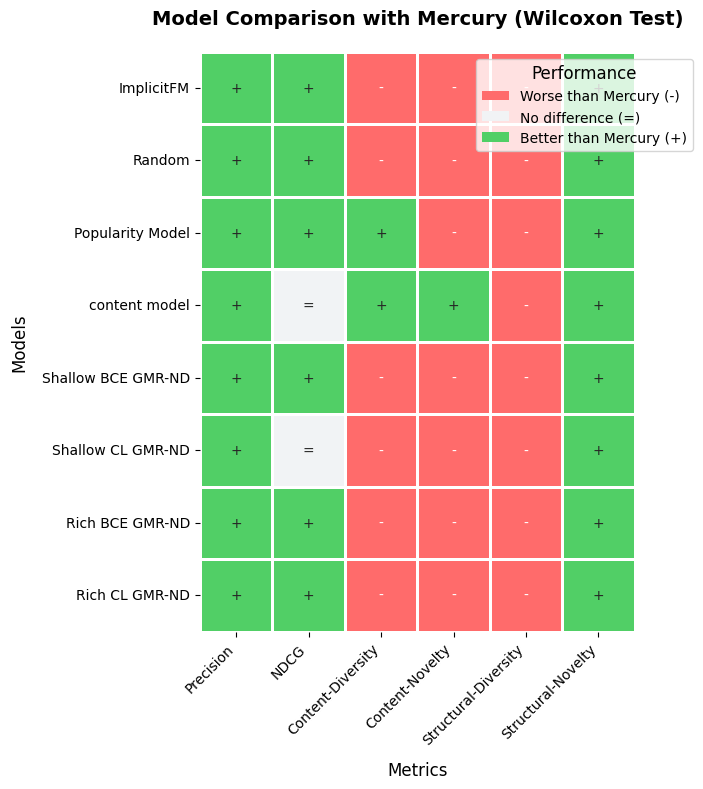

In [111]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def create_stylish_heatmap(significance_table):
    # Convert symbols to numeric values for coloring
    numeric_table = significance_table.replace({'+': 1, '-': -1, '=': 0, 'N/A': np.nan})
    
    # Create custom colormap
    colors = ['#ff6b6b', '#f1f3f5', '#51cf66']  # Red, Light Gray, Green
    n_bins = 3
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Create the heatmap
    ax = sns.heatmap(numeric_table, 
                     cmap=cmap,
                     center=0,
                     annot=significance_table.values,
                     fmt='',
                     cbar=False,
                     square=True,
                     linewidths=1,
                     linecolor='white',
                     mask=numeric_table.isna())
    
    # Customize the plot
    plt.title('Model Comparison with Mercury (Wilcoxon Test)', 
             pad=20, 
             fontsize=14, 
             fontweight='bold')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add labels
    plt.xlabel('Metrics', fontsize=12, labelpad=10)
    plt.ylabel('Models', fontsize=12, labelpad=10)
    
    # Add a legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[0], label='Worse than Mercury (-)'),
                      plt.Rectangle((0,0),1,1, facecolor=colors[1], label='No difference (=)'),
                      plt.Rectangle((0,0),1,1, facecolor=colors[2], label='Better than Mercury (+)')]
    
    plt.legend(handles=legend_elements, 
              bbox_to_anchor=(1.15, 1),
              title='Performance',
              title_fontsize=12,
              fontsize=10)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Create and display the heatmap
fig = create_stylish_heatmap(significance_table_cox)
plt.show()

# Optionally save the figure
# fig.savefig('wilcoxon_comparison.png', dpi=300, bbox_inches='tight')

## Kruskal Wallis / ANOVA


Analysis for User-Precision
--------------------------------------------------
Kruskal-Wallis H-statistic: 1443.5765
P-value: 2.1391e-306
There are significant differences between models

Comparison Matrix:
                   MRecuri ImplicitFM Random Popularity Model content model  \
MRecuri                  X          +      +                -             =   
ImplicitFM               -          X      +                -             -   
Random                   -          -      X                -             -   
Popularity Model         +          +      +                X             +   
content model            =          +      +                -             X   
Shallow BCE GMR-ND       =          +      +                -             =   
Shallow CL GMR-ND        =          +      +                -             =   
Rich BCE GMR-ND          -          -      =                -             -   
Rich CL GMR-ND           -          -      =                -             -   

 

C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\530755682.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(matrix.replace({'X': 0, '+': 1, '-': -1, '=': 0}).astype(float),



Analysis for User-NDCG
--------------------------------------------------
Kruskal-Wallis H-statistic: 1436.2526
P-value: 8.2030e-305
There are significant differences between models

Comparison Matrix:
                   MRecuri ImplicitFM Random Popularity Model content model  \
MRecuri                  X          +      +                -             =   
ImplicitFM               -          X      +                -             -   
Random                   -          -      X                -             -   
Popularity Model         +          +      +                X             +   
content model            =          +      +                -             X   
Shallow BCE GMR-ND       =          +      +                -             =   
Shallow CL GMR-ND        =          +      +                -             =   
Rich BCE GMR-ND          -          -      =                -             -   
Rich CL GMR-ND           -          -      =                -             -   

      

C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\530755682.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(matrix.replace({'X': 0, '+': 1, '-': -1, '=': 0}).astype(float),



Analysis for User-Content-Diversity
--------------------------------------------------
Kruskal-Wallis H-statistic: 23980.4710
P-value: 0.0000e+00
There are significant differences between models

Comparison Matrix:
                   MRecuri ImplicitFM Random Popularity Model content model  \
MRecuri                  X          -      -                +             +   
ImplicitFM               +          X      -                +             +   
Random                   +          +      X                +             +   
Popularity Model         -          -      -                X             +   
content model            -          -      -                -             X   
Shallow BCE GMR-ND       +          +      -                +             +   
Shallow CL GMR-ND        +          +      -                +             +   
Rich BCE GMR-ND          +          +      -                +             +   
Rich CL GMR-ND           +          +      =                +            

C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\530755682.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(matrix.replace({'X': 0, '+': 1, '-': -1, '=': 0}).astype(float),


Kruskal-Wallis H-statistic: 9908.5814
P-value: 0.0000e+00
There are significant differences between models

Comparison Matrix:
                   MRecuri ImplicitFM Random Popularity Model content model  \
MRecuri                  X          -      -                =             +   
ImplicitFM               +          X      -                +             +   
Random                   +          +      X                +             +   
Popularity Model         =          -      -                X             +   
content model            -          -      -                -             X   
Shallow BCE GMR-ND       +          -      -                +             +   
Shallow CL GMR-ND        +          -      -                +             +   
Rich BCE GMR-ND          +          -      -                +             +   
Rich CL GMR-ND           +          +      -                +             +   

                   Shallow BCE GMR-ND Shallow CL GMR-ND Rich BCE GMR-ND  \
MRecuri

C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\530755682.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(matrix.replace({'X': 0, '+': 1, '-': -1, '=': 0}).astype(float),


Kruskal-Wallis H-statistic: 25660.5280
P-value: 0.0000e+00
There are significant differences between models

Comparison Matrix:
                   MRecuri ImplicitFM Random Popularity Model content model  \
MRecuri                  X          -      -                -             -   
ImplicitFM               +          X      -                +             -   
Random                   +          +      X                +             +   
Popularity Model         +          -      -                X             -   
content model            +          +      -                +             X   
Shallow BCE GMR-ND       +          +      -                +             +   
Shallow CL GMR-ND        +          +      -                +             +   
Rich BCE GMR-ND          +          +      -                +             +   
Rich CL GMR-ND           +          +      +                +             +   

                   Shallow BCE GMR-ND Shallow CL GMR-ND Rich BCE GMR-ND  \
MRecur

C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\530755682.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(matrix.replace({'X': 0, '+': 1, '-': -1, '=': 0}).astype(float),


Kruskal-Wallis H-statistic: 8776.3598
P-value: 0.0000e+00
There are significant differences between models

Comparison Matrix:
                   MRecuri ImplicitFM Random Popularity Model content model  \
MRecuri                  X          +      +                +             +   
ImplicitFM               -          X      -                -             +   
Random                   -          +      X                +             +   
Popularity Model         -          +      -                X             +   
content model            -          -      -                -             X   
Shallow BCE GMR-ND       -          +      -                -             +   
Shallow CL GMR-ND        -          +      -                -             +   
Rich BCE GMR-ND          -          +      =                +             +   
Rich CL GMR-ND           -          +      +                +             +   

                   Shallow BCE GMR-ND Shallow CL GMR-ND Rich BCE GMR-ND  \
MRecuri

C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\530755682.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(matrix.replace({'X': 0, '+': 1, '-': -1, '=': 0}).astype(float),


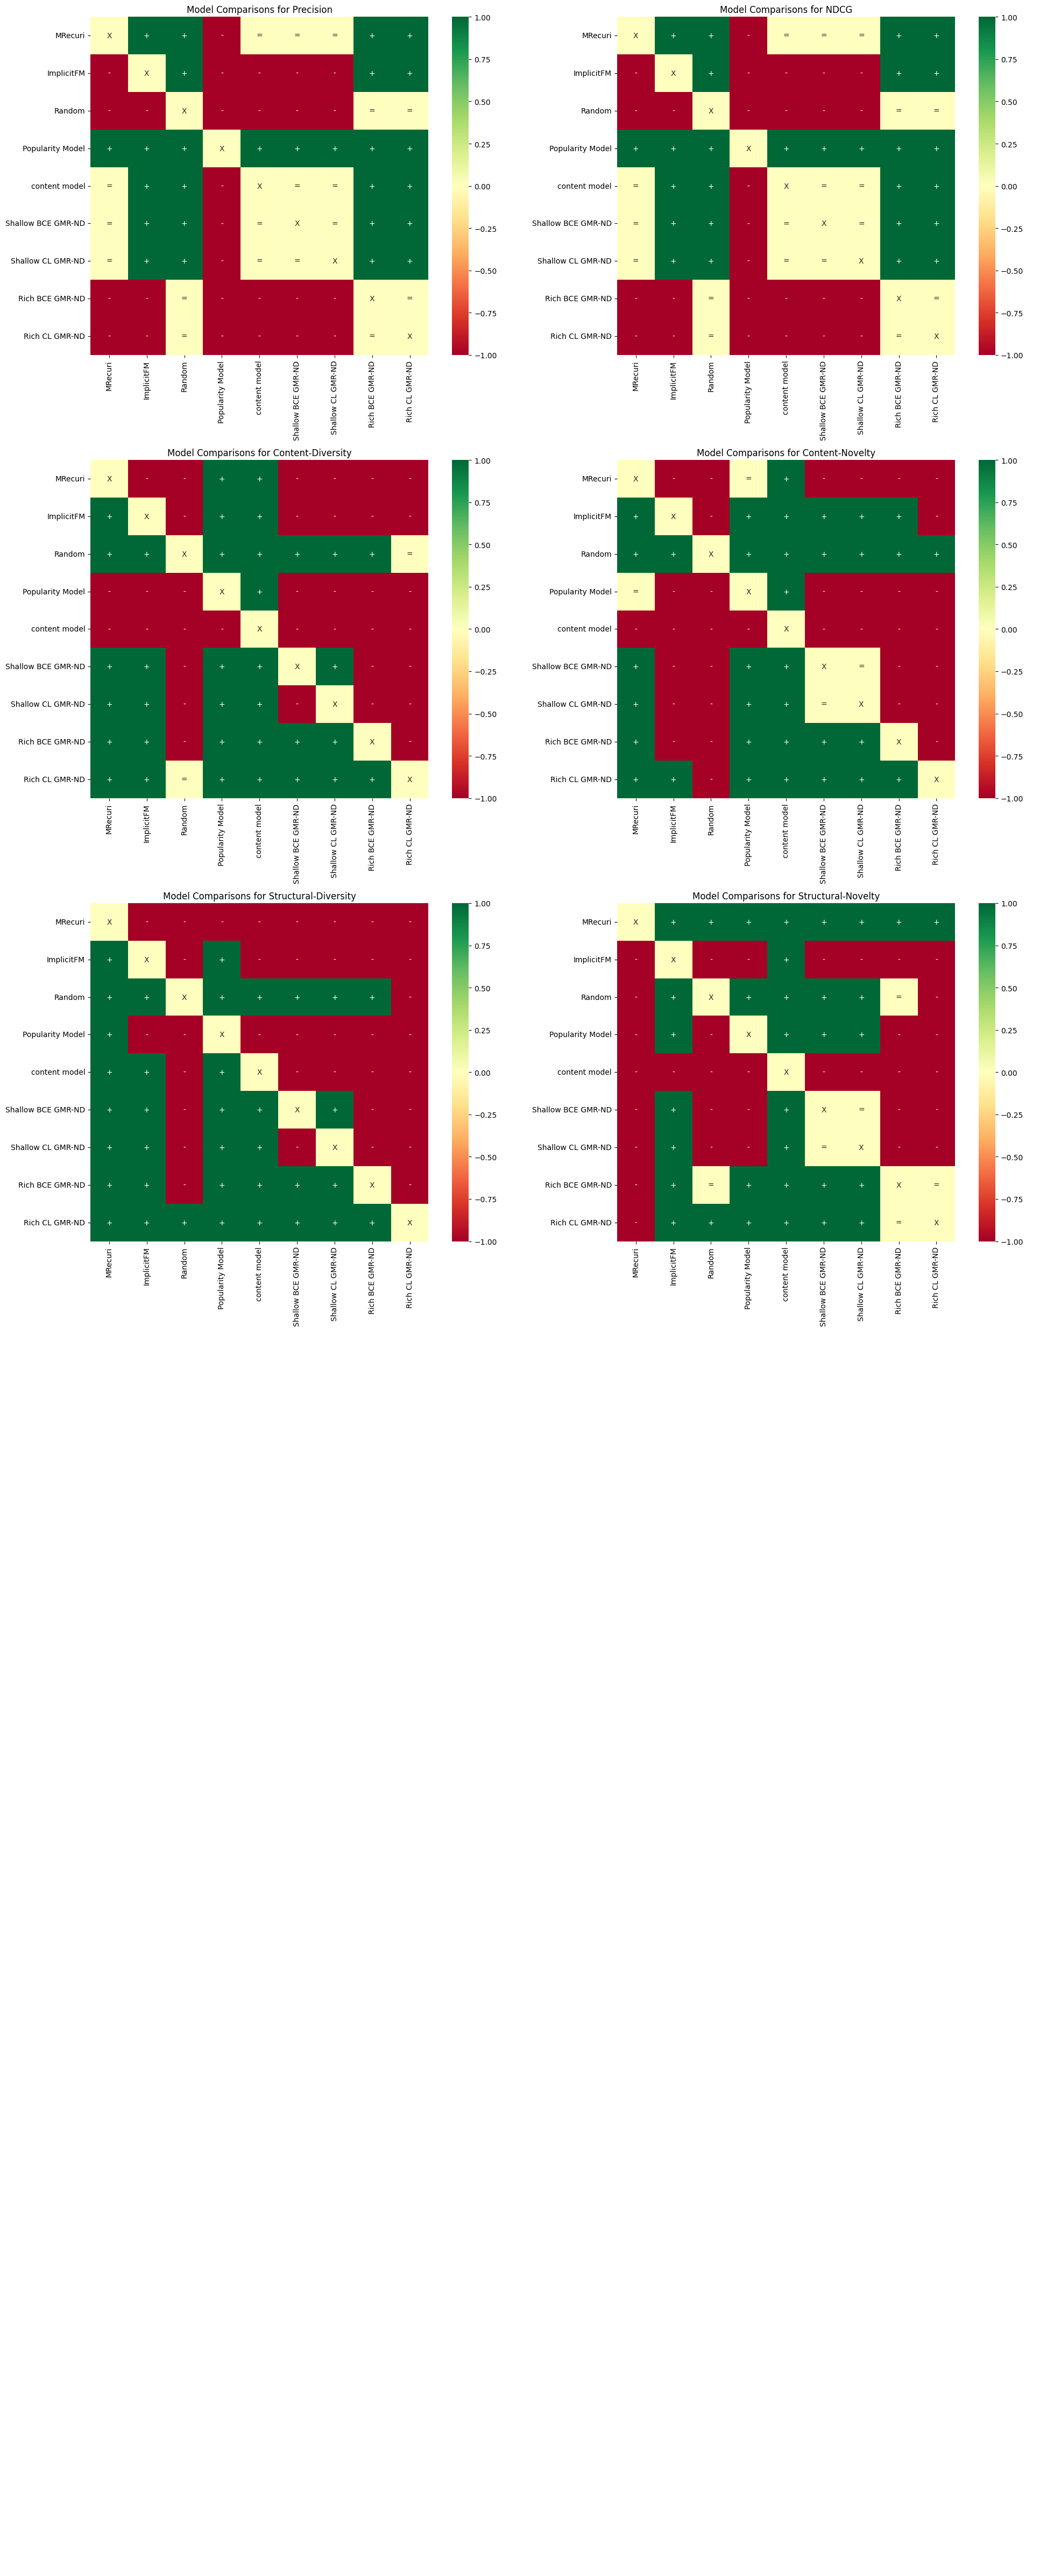

In [112]:
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def perform_kruskal_wallis(user_scores, metric):
    # Get all models except the original-user-track-graph
    models = [model for model in user_scores.keys() if model != 'original-user-track-graph']
    
    # Collect scores for each model
    scores = []
    model_names = []
    
    for model in models:
        if metric in user_scores[model]:
            model_scores = np.array(user_scores[model][metric])
            valid_scores = model_scores[~np.isnan(model_scores)]
            scores.append(valid_scores)
            model_names.append(model)
    
    # Perform Kruskal-Wallis H-test
    h_statistic, p_value = stats.kruskal(*scores)
    
    # Create comparison matrix
    comparison_matrix = pd.DataFrame(index=models, columns=models)
    
    # If significant difference found, perform post-hoc pairwise Mann-Whitney U tests
    if p_value < 0.01:
        for i, model1 in enumerate(models):
            for j, model2 in enumerate(models):
                if model1 == model2:
                    comparison_matrix.loc[model1, model2] = 'X'
                else:
                    stat, p = stats.mannwhitneyu(scores[i], scores[j], alternative='two-sided')
                    if p < 0.01:
                        mean1 = np.mean(scores[i])
                        mean2 = np.mean(scores[j])
                        comparison_matrix.loc[model1, model2] = '+' if mean1 > mean2 else '-'
                    else:
                        comparison_matrix.loc[model1, model2] = '='
    
    return comparison_matrix, h_statistic, p_value

# Run analysis for each metric
metrics = ['User-Precision', 'User-NDCG', 'User-Content-Diversity', 
          'User-Content-Novelty', 'User-Structural-Diversity', 'User-Structural-Novelty']

models_to_test = ['MRecuri', 'ImplicitFM', 'Random', 'Popularity Model', 
                 'content model', 'Shallow BCE GMR-ND', 'Shallow CL GMR-ND', 
                 'Rich BCE GMR-ND', 'Rich CL GMR-ND']

# Store all comparison matrices
all_results = {}

# Create a figure with subplots for each metric, with 2 columns
fig, axs = plt.subplots(len(metrics), 2, figsize=(20, 8 * len(metrics)))

# Flatten the axs array if it's not already 1D
if len(axs.shape) > 1:
    axs = axs.flatten()

for i, metric in enumerate(metrics):
    print(f"\nAnalysis for {metric}")
    print("-" * 50)
    
    matrix, h_stat, p_val = perform_kruskal_wallis(user_scores, metric)
    print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_val:.4e}")
    
    if p_val < 0.01:
        print("There are significant differences between models")
        print("\nComparison Matrix:")
        print(matrix)
        
        # Create heatmap for the current metric
        if not matrix.empty:
            sns.heatmap(matrix.replace({'X': 0, '+': 1, '-': -1, '=': 0}).astype(float),
                       annot=matrix.values,
                       fmt='',
                       cmap='RdYlGn',
                       center=0,
                       square=True,
                       ax=axs[i])
            axs[i].set_title(f'Model Comparisons for {metric.replace("User-", "")}')
            axs[i].set_xlabel('')
            axs[i].set_ylabel('')
    else:
        print("No significant differences between models")
    
    all_results[metric] = matrix

# Remove empty subplots
for ax in axs:
    if not ax.has_data():
        ax.axis('off')

plt.tight_layout()
plt.show()

### GMR ND MODEL VARIANTS (Not used)


In [45]:
user_scores.keys()

dict_keys(['mercury', 'implicitfm', 'random_model', 'popularity_model', 'content_model', 'model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum', 'original-user-track-graph'])

C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\1124885488.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_matrix = matrix.replace({'+': 1, '-': -1, '=': 0, 'X': 0})
C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\1124885488.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_matrix = matrix.replace({'+': 1, '-': -1, '=': 0, 'X': 0})
C:\Users\Timo\AppData\Local\Temp\ipykernel_54184\1124885488.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To re

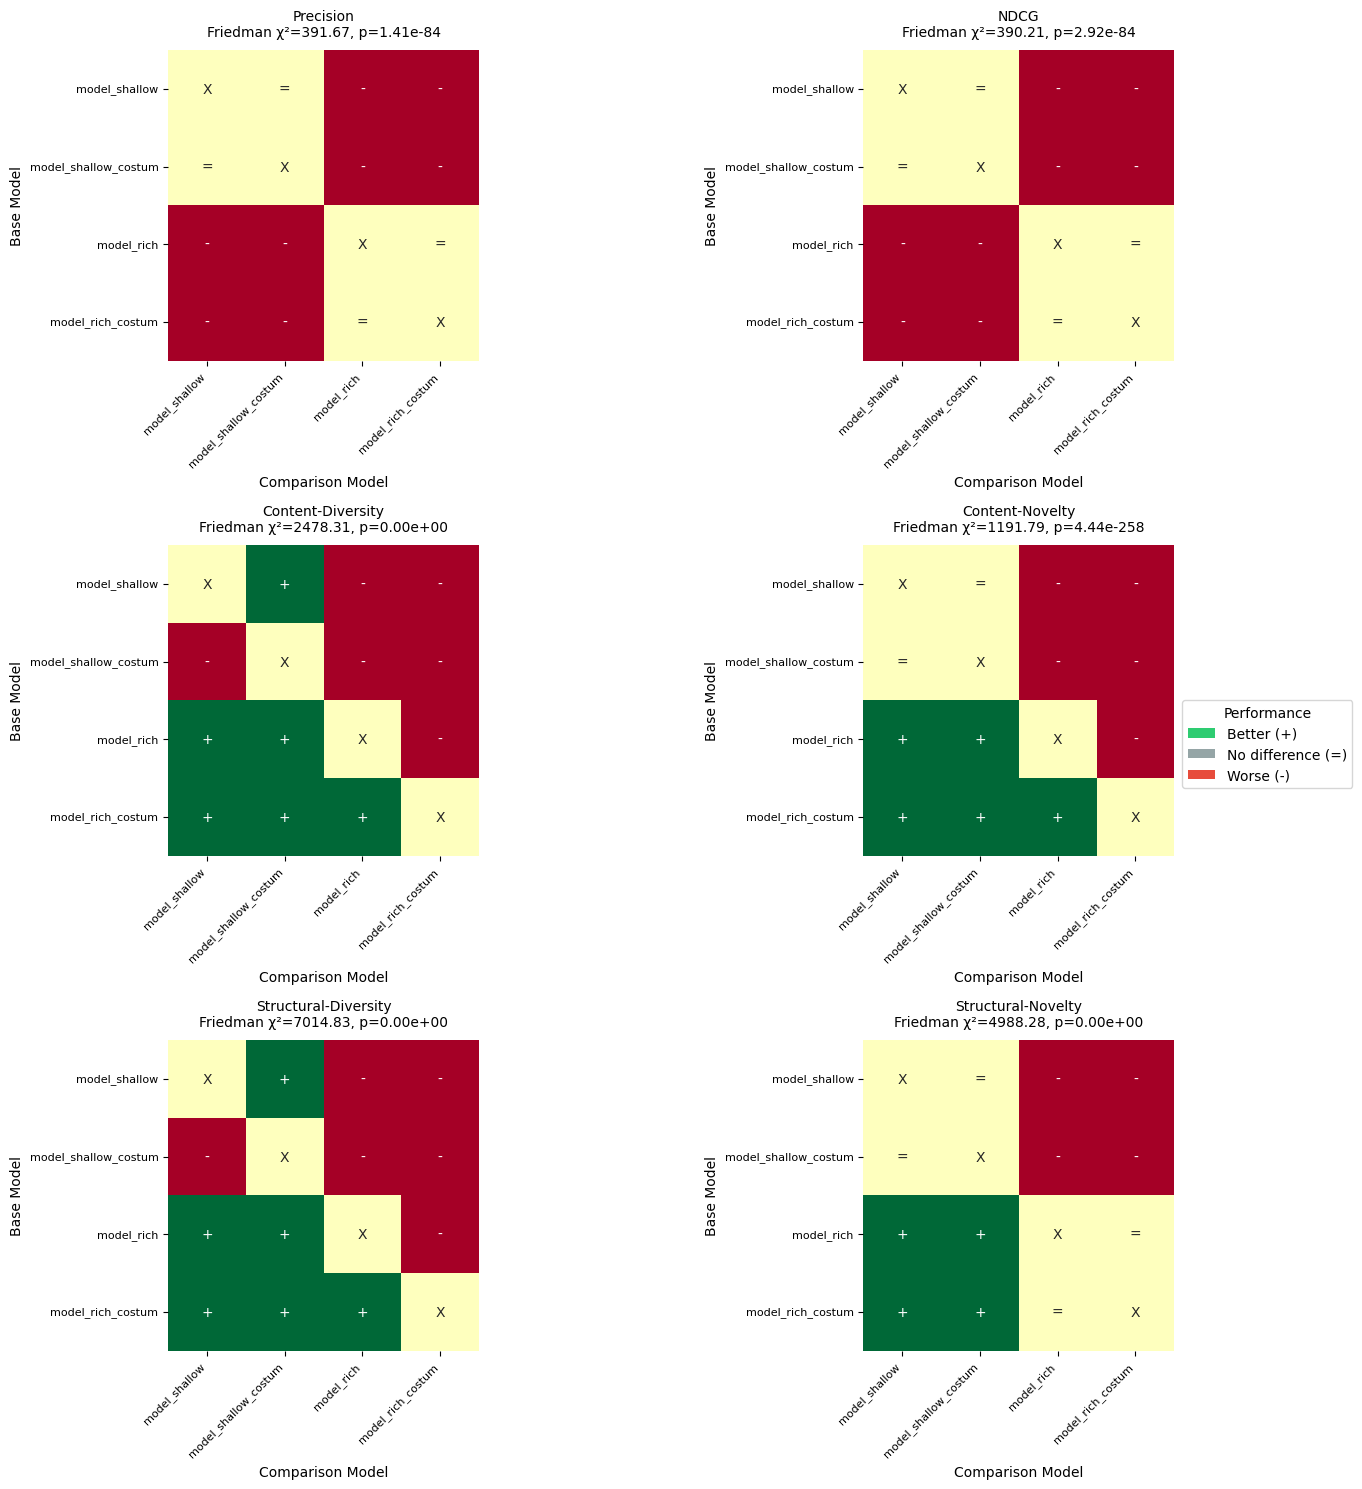


Detailed Statistics:
--------------------------------------------------

User-Precision
Friedman χ² = 391.67
p-value = 1.41e-84

User-NDCG
Friedman χ² = 390.21
p-value = 2.92e-84

User-Content-Diversity
Friedman χ² = 2478.31
p-value = 0.00e+00

User-Content-Novelty
Friedman χ² = 1191.79
p-value = 4.44e-258

User-Structural-Diversity
Friedman χ² = 7014.83
p-value = 0.00e+00

User-Structural-Novelty
Friedman χ² = 4988.28
p-value = 0.00e+00


In [46]:
from scipy import stats
import pandas as pd
import numpy as np
from scikit_posthocs import posthoc_nemenyi_friedman
import seaborn as sns
import matplotlib.pyplot as plt

def perform_friedman_analysis(user_scores, metric, selected_models):
    # Create DataFrame with scores from selected models
    scores_dict = {}
    for model in selected_models:
        if metric in user_scores[model]:
            scores_dict[model] = user_scores[model][metric]
    
    scores_df = pd.DataFrame(scores_dict)
    
    # Perform Friedman test
    statistic, p_value = stats.friedmanchisquare(*[scores_df[col].dropna() for col in scores_df.columns])
    
    # Create comparison matrix
    comparison_matrix = pd.DataFrame(index=selected_models, columns=selected_models)
    
    # If Friedman test is significant, perform post-hoc Nemenyi test
    if p_value < 0.01:
        # Perform Nemenyi post-hoc test
        posthoc = posthoc_nemenyi_friedman(scores_df)
        
        # Fill comparison matrix
        for model1 in selected_models:
            for model2 in selected_models:
                if model1 != model2:
                    p_val = posthoc.loc[model1, model2]
                    if p_val < 0.01:
                        median1 = np.nanmedian(scores_df[model1])
                        median2 = np.nanmedian(scores_df[model2])
                        comparison_matrix.loc[model1, model2] = '+' if median1 > median2 else '-'
                    else:
                        comparison_matrix.loc[model1, model2] = '='
                else:
                    comparison_matrix.loc[model1, model2] = 'X'
    else:
        # If Friedman test is not significant, all comparisons are equal
        for model1 in selected_models:
            for model2 in selected_models:
                comparison_matrix.loc[model1, model2] = '=' if model1 != model2 else 'X'
    
    return comparison_matrix, statistic, p_value

# Select only GNN models
gnn_models = ['model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum']

metrics = ['User-Precision', 'User-NDCG', 'User-Content-Diversity', 
          'User-Content-Novelty', 'User-Structural-Diversity', 'User-Structural-Novelty']

# Perform analysis for each metric
all_comparisons = {}
for metric in metrics:
    matrix, stat, p_val = perform_friedman_analysis(user_scores, metric, gnn_models)
    all_comparisons[metric] = {
        'matrix': matrix,
        'statistic': stat,
        'p_value': p_val
    }

# Create visualization
def create_gnn_heatmaps(all_comparisons, metrics):
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    colors = {'red': '#e74c3c', 'grey': '#95a5a6', 'green': '#2ecc71'}
    
    for idx, metric in enumerate(metrics):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        matrix = all_comparisons[metric]['matrix']
        stat = all_comparisons[metric]['statistic']
        p_val = all_comparisons[metric]['p_value']
        
        # Create numeric matrix for coloring
        numeric_matrix = matrix.replace({'+': 1, '-': -1, '=': 0, 'X': 0})
        
        # Create heatmap
        sns.heatmap(numeric_matrix.astype(float), 
                   cmap='RdYlGn',
                   center=0,
                   annot=matrix.values,
                   fmt='',
                   cbar=False,
                   square=True,
                   ax=ax)
        
        # Add Friedman test results to title
        title = f'{metric.replace("User-", "")}\n'
        title += f'Friedman χ²={stat:.2f}, p={p_val:.2e}'
        ax.set_title(title, fontsize=10, pad=10)
        ax.set_xlabel('Comparison Model', fontsize=10)
        ax.set_ylabel('Base Model', fontsize=10)
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)
    
    # Remove empty subplots if any
    if n_metrics < n_rows * n_cols:
        for idx in range(n_metrics, n_rows * n_cols):
            fig.delaxes(axes[idx // n_cols, idx % n_cols])
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['green'], label='Better (+)'),
                      plt.Rectangle((0,0),1,1, facecolor=colors['grey'], label='No difference (=)'),
                      plt.Rectangle((0,0),1,1, facecolor=colors['red'], label='Worse (-)')]
    
    fig.legend(handles=legend_elements, 
              loc='center right', 
              bbox_to_anchor=(0.98, 0.5),
              title='Performance')
    
    plt.tight_layout()
    return fig

# Create and display the visualizations
fig = create_gnn_heatmaps(all_comparisons, metrics)
plt.show()

# Save the figure
fig.savefig('gnn_model_comparisons_friedman.png', bbox_inches='tight', dpi=300)

# Print detailed statistics
print("\nDetailed Statistics:")
print("-" * 50)
for metric in metrics:
    print(f"\n{metric}")
    print(f"Friedman χ² = {all_comparisons[metric]['statistic']:.2f}")
    print(f"p-value = {all_comparisons[metric]['p_value']:.2e}")

# Final Tables

In [53]:
evaluation_df = pd.read_csv('data/benchmark_models/tables/evaluation_df.csv')

In [148]:
significance_table_cox

,Precision,NDCG,Content-Diversity,Content-Novelty,Structural-Diversity,Structural-Novelty
implicitfm,+,+,-,-,-,+
random_model,+,+,-,-,-,+
popularity_model,-,-,+,-,-,+
content_model,+,=,+,+,-,+
model_shallow,+,=,-,-,-,+
model_shallow_costum,+,=,-,-,-,+
model_rich,+,+,-,-,-,+
model_rich_costum,+,+,-,-,-,+


In [149]:
evaluation_df

,Precision,NDCG,Content Diversity,Content Novelty,Structural Diversity,Structural Novelty
Mercury,0.0142 ± 0.0631,0.0376 ± 0.1457,2.8380 ± 0.0757,5.4093 ± 0.9766,0.1068 ± 0.0072,0.8620 ± 0.3193
ImplicitMF,0.0047 ± 0.0273,0.0158 ± 0.0880,4.2648 ± 1.0212,6.0733 ± 0.9754,0.2907 ± 0.1000,0.6591 ± 0.2096
Random Model,0.0006 ± 0.0078,0.0029 ± 0.0415,6.2934 ± 0.6283,6.2284 ± 0.5363,0.8847 ± 0.0980,0.8246 ± 0.1058
Popularity Model,0.0388 ± 0.1071,0.1011 ± 0.2386,2.1994 ± 0.0000,5.4522 ± 1.0481,0.1192 ± 0.0000,0.7287 ± 0.2541
content_based_model,0.0095 ± 0.0369,0.0361 ± 0.1375,1.9448 ± 0.6850,4.1489 ± 0.6064,0.5093 ± 0.2058,0.5263 ± 0.1646
model_shallow,0.0067 ± 0.0271,0.0294 ± 0.1256,5.4820 ± 0.6359,5.8775 ± 0.6668,0.5505 ± 0.1010,0.6717 ± 0.1254
model_shallow_costum,0.0089 ± 0.0334,0.0372 ± 0.1426,5.3723 ± 0.7565,5.8576 ± 0.6970,0.5370 ± 0.1673,0.6668 ± 0.1374
model_rich,0.0005 ± 0.0067,0.0021 ± 0.0351,5.6241 ± 0.4743,5.9284 ± 0.4969,0.8774 ± 0.0801,0.8259 ± 0.0946
model_rich_costum,0.0006 ± 0.0080,0.0025 ± 0.0319,6.2615 ± 0.5785,6.1555 ± 0.5640,0.9177 ± 0.0724,0.8302 ± 0.0868
Original-User-Track-Graph,nan ± nan,nan ± nan,4.8358 ± 0.7818,1.2250 ± 0.7855,0.5010 ± 0.1623,0.1595 ± 0.1295


In [150]:
# Switch the columns Content Novelty and Structural Diversity
columns = evaluation_df.columns.tolist()
content_novelty_index = columns.index('Content Novelty')
structural_diversity_index = columns.index('Structural Diversity')
columns[content_novelty_index], columns[structural_diversity_index] = columns[structural_diversity_index], columns[content_novelty_index]

# Create a new DataFrame with the reordered columns
evaluation_df_reordered = evaluation_df[columns]

# Display the reordered DataFrame
display(evaluation_df_reordered)

# Update the original evaluation_df
evaluation_df = evaluation_df_reordered


,Precision,NDCG,Content Diversity,Structural Diversity,Content Novelty,Structural Novelty
Mercury,0.0142 ± 0.0631,0.0376 ± 0.1457,2.8380 ± 0.0757,0.1068 ± 0.0072,5.4093 ± 0.9766,0.8620 ± 0.3193
ImplicitMF,0.0047 ± 0.0273,0.0158 ± 0.0880,4.2648 ± 1.0212,0.2907 ± 0.1000,6.0733 ± 0.9754,0.6591 ± 0.2096
Random Model,0.0006 ± 0.0078,0.0029 ± 0.0415,6.2934 ± 0.6283,0.8847 ± 0.0980,6.2284 ± 0.5363,0.8246 ± 0.1058
Popularity Model,0.0388 ± 0.1071,0.1011 ± 0.2386,2.1994 ± 0.0000,0.1192 ± 0.0000,5.4522 ± 1.0481,0.7287 ± 0.2541
content_based_model,0.0095 ± 0.0369,0.0361 ± 0.1375,1.9448 ± 0.6850,0.5093 ± 0.2058,4.1489 ± 0.6064,0.5263 ± 0.1646
model_shallow,0.0067 ± 0.0271,0.0294 ± 0.1256,5.4820 ± 0.6359,0.5505 ± 0.1010,5.8775 ± 0.6668,0.6717 ± 0.1254
model_shallow_costum,0.0089 ± 0.0334,0.0372 ± 0.1426,5.3723 ± 0.7565,0.5370 ± 0.1673,5.8576 ± 0.6970,0.6668 ± 0.1374
model_rich,0.0005 ± 0.0067,0.0021 ± 0.0351,5.6241 ± 0.4743,0.8774 ± 0.0801,5.9284 ± 0.4969,0.8259 ± 0.0946
model_rich_costum,0.0006 ± 0.0080,0.0025 ± 0.0319,6.2615 ± 0.5785,0.9177 ± 0.0724,6.1555 ± 0.5640,0.8302 ± 0.0868
Original-User-Track-Graph,nan ± nan,nan ± nan,4.8358 ± 0.7818,0.5010 ± 0.1623,1.2250 ± 0.7855,0.1595 ± 0.1295


In [152]:
significance_table

,Precision,NDCG,Content-Diversity,Content-Novelty,Structural-Diversity,Structural-Novelty
implicitfm,+,+,-,-,-,+
random_model,+,+,-,-,-,+
popularity_model,-,-,+,-,-,+
content_model,+,=,+,+,-,+
model_shallow,+,=,-,-,-,+
model_shallow_costum,+,=,-,-,-,+
model_rich,+,+,-,-,-,+
model_rich_costum,+,+,-,-,-,+


In [151]:
import os

# Define the path to save the tables
save_path = 'data/benchmark_models/tables'

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save the significance table to CSV
significance_table.to_csv(os.path.join(save_path, 'significance_table.csv'), index=True)

# Save the evaluation dataframe to CSV
evaluation_df.to_csv(os.path.join(save_path, 'evaluation_df.csv'), index=True)


## Unique Number of Tracks in the test set

In [ ]:
model_names = ['model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum']

for model in model_names:
    model_predictions_10 = pd.read_csv(f'data/gnn_models/predictions/topk10_predictions_{model}.csv')

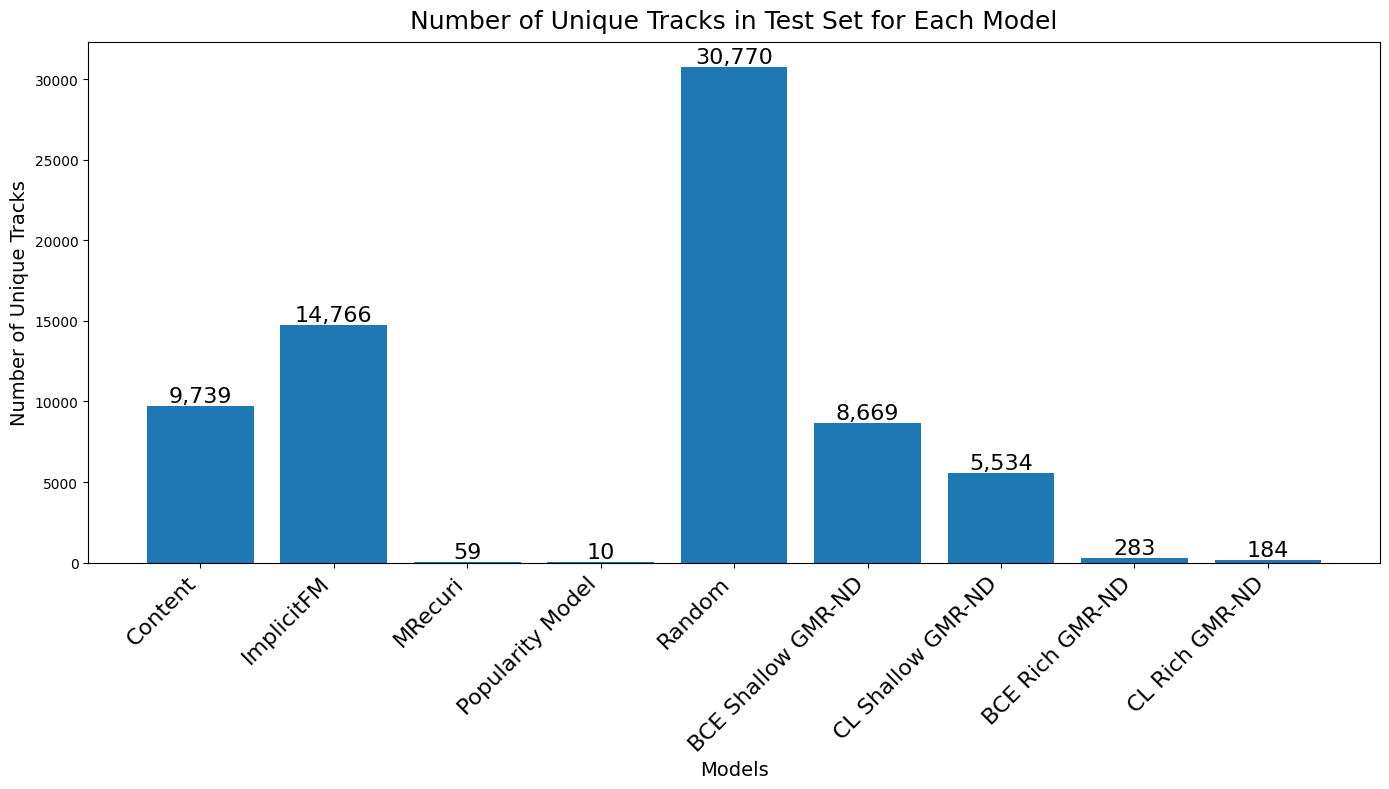

Content: 9,739 unique tracks
ImplicitFM: 14,766 unique tracks
MRecuri: 59 unique tracks
Popularity Model: 10 unique tracks
Random: 30,770 unique tracks
BCE Shallow GMR-ND: 8,669 unique tracks
CL Shallow GMR-ND: 5,534 unique tracks
BCE Rich GMR-ND: 283 unique tracks
CL Rich GMR-ND: 184 unique tracks


In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the prediction CSVs
benchmark_path = 'data/benchmark_models/prediction_csvs'
gnn_path = 'data/gnn_models/predictions'

# Dictionary to store unique track counts
unique_tracks = {}

# Load benchmark CSV files and count unique tracks
for filename in os.listdir(benchmark_path):
    if filename.endswith('.csv'):
        model_name = filename.split('.')[0]
        df = pd.read_csv(os.path.join(benchmark_path, filename))
        unique_tracks[model_name] = df['Track ID'].nunique()

# Load GNN model CSV files and count unique tracks
gnn_models = ['model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum']
for model in gnn_models:
    filename = f'topk10_predictions_{model}.csv'
    df = pd.read_csv(os.path.join(gnn_path, filename))
    unique_tracks[model] = df['Song ID'].nunique()

# Rename models according to the provided list
new_names = ['Content', 'ImplicitFM', 'MRecuri', 'Popularity Model', 'Random', 
             'BCE Shallow GMR-ND', 'CL Shallow GMR-ND', 
             'BCE Rich GMR-ND', 'CL Rich GMR-ND']
old_names = ['content_model_recommendations', 'implicit_mf_recommendations','mercury_predictions',
             'popularity_model_predictions', 'random_model_predictions',
             'model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum'  ]
for old, new in zip(old_names, new_names):
    if old in unique_tracks:
        unique_tracks[new] = unique_tracks.pop(old)

# Create bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(unique_tracks.keys(), unique_tracks.values())
plt.title('Number of Unique Tracks in Test Set for Each Model', fontsize=18, pad = 10)  # Increased font size for title
plt.xlabel('Models', fontsize=14)  # Increased font size for x-axis label
plt.ylabel('Number of Unique Tracks', fontsize=14)  # Increased font size for y-axis label
plt.xticks(rotation=45, ha='right', fontsize=16)  # Increased font size for x-axis ticks

# Add the number above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom', fontsize=16)  # Increased font size for bar labels

plt.tight_layout()
plt.show()

# Print the results
for model, count in unique_tracks.items():
    print(f"{model}: {count:,} unique tracks")

content_model_recommendations
implicit_mf_recommendations
mercury_predictions
popularity_model_predictions
random_model_predictions


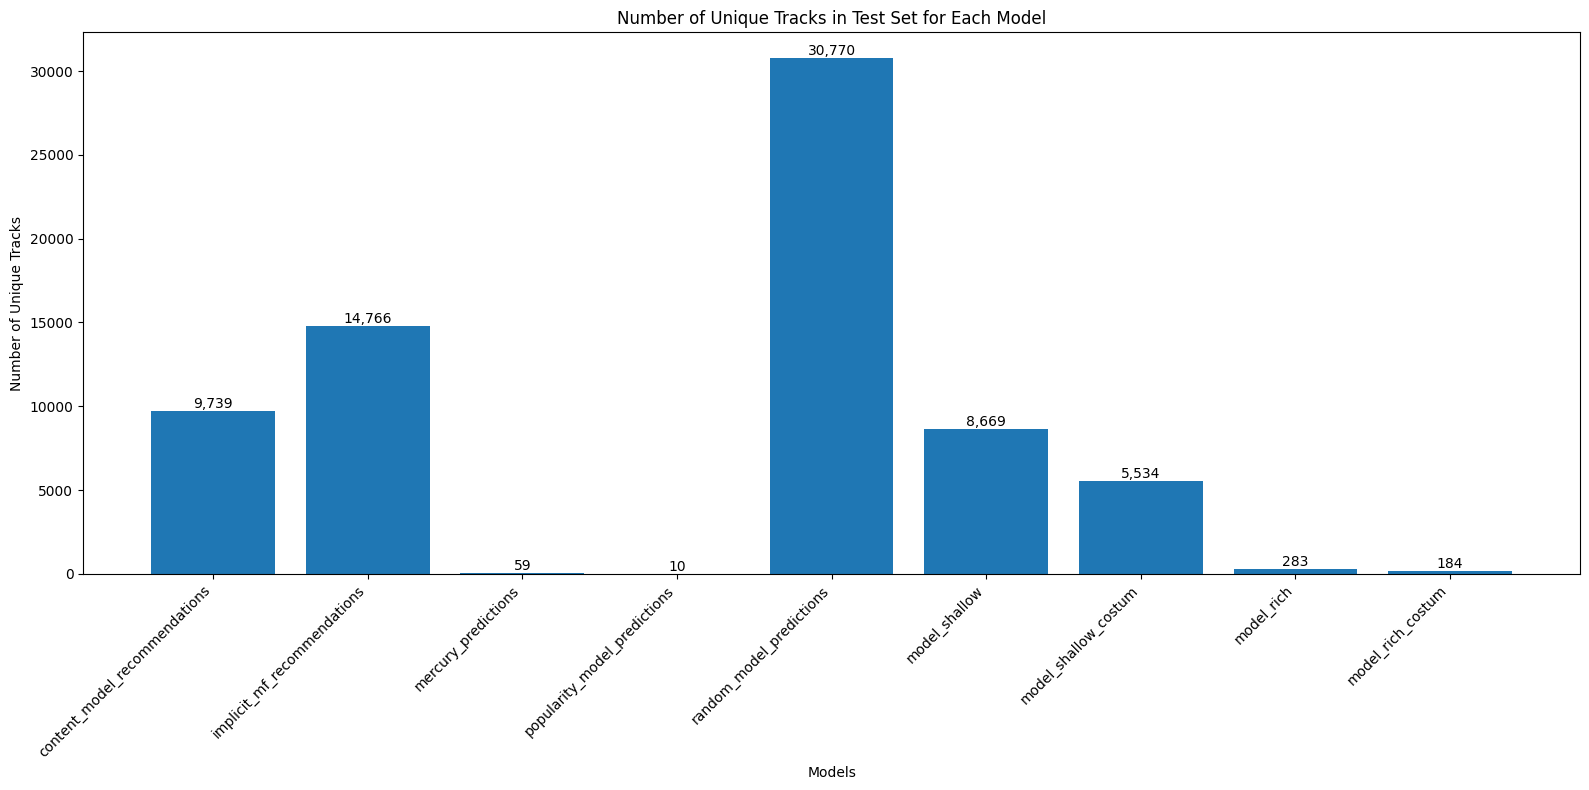

content_model_recommendations: 9,739 unique tracks
implicit_mf_recommendations: 14,766 unique tracks
mercury_predictions: 59 unique tracks
popularity_model_predictions: 10 unique tracks
random_model_predictions: 30,770 unique tracks
model_shallow: 8,669 unique tracks
model_shallow_costum: 5,534 unique tracks
model_rich: 283 unique tracks
model_rich_costum: 184 unique tracks


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the prediction CSVs
benchmark_path = 'data/benchmark_models/prediction_csvs'
gnn_path = 'data/gnn_models/predictions'

# Dictionary to store unique track counts
unique_tracks = {}

# Load benchmark CSV files and count unique tracks
for filename in os.listdir(benchmark_path):
    if filename.endswith('.csv'):
        model_name = filename.split('.')[0]
        print(model_name)
        df = pd.read_csv(os.path.join(benchmark_path, filename))
        unique_tracks[model_name] = df['Track ID'].nunique()

# Load GNN model CSV files and count unique tracks
gnn_models = ['model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum']
for model in gnn_models:
    filename = f'topk10_predictions_{model}.csv'
    df = pd.read_csv(os.path.join(gnn_path, filename))
    unique_tracks[model] = df['Song ID'].nunique()

# Create bar chart
plt.figure(figsize=(16, 8))
bars = plt.bar(unique_tracks.keys(), unique_tracks.values())
plt.title('Number of Unique Tracks in Test Set for Each Model')
plt.xlabel('Models')
plt.ylabel('Number of Unique Tracks')
plt.xticks(rotation=45, ha='right')

# Add the number above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the results
for model, count in unique_tracks.items():
    print(f"{model}: {count:,} unique tracks")

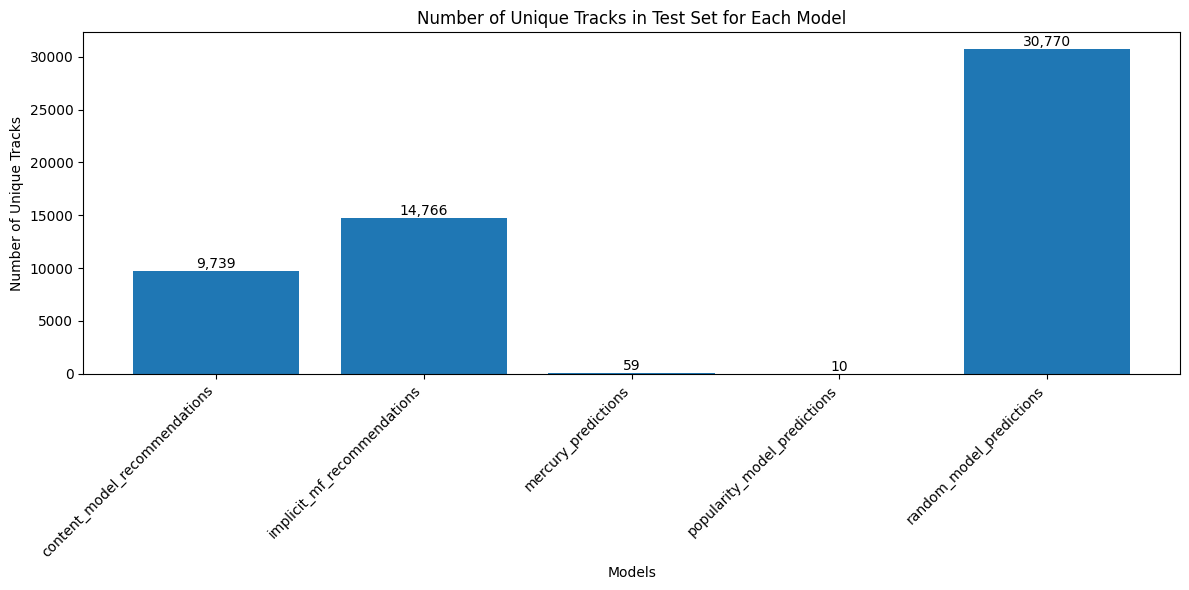

content_model_recommendations: 9,739 unique tracks
implicit_mf_recommendations: 14,766 unique tracks
mercury_predictions: 59 unique tracks
popularity_model_predictions: 10 unique tracks
random_model_predictions: 30,770 unique tracks


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to the prediction CSVs
prediction_path = 'data/benchmark_models/prediction_csvs'

# Dictionary to store unique track counts
unique_tracks = {}

# Load all CSV files and count unique tracks
for filename in os.listdir(prediction_path):
    if filename.endswith('.csv'):
        model_name = filename.split('.')[0]
        df = pd.read_csv(os.path.join(prediction_path, filename))
        unique_tracks[model_name] = df['Track ID'].nunique()

# Create bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(unique_tracks.keys(), unique_tracks.values())
plt.title('Number of Unique Tracks in Test Set for Each Model')
plt.xlabel('Models')
plt.ylabel('Number of Unique Tracks')
plt.xticks(rotation=45, ha='right')

# Add the number above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the results
for model, count in unique_tracks.items():
    print(f"{model}: {count:,} unique tracks")

## Debugging Analysis

In [ ]:
import numpy as np
from scipy import stats

def perform_paired_ttest(model1_scores, model2_scores, model1_name, model2_name):
    t_statistic, p_value = stats.ttest_rel(model1_scores, model2_scores)
    
    print(f"Paired t-test results for {model1_name} vs {model2_name}:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.01:
        if t_statistic > 0:
            print(f"{model1_name} performs significantly better than {model2_name}")
        else:
            print(f"{model2_name} performs significantly better than {model1_name}")
    else:
        print("No significant difference between the two models")



In [ ]:
# Assuming you have these arrays:
mercury_precision = np.array(user_scores["mercury"]['User-Precision'])
implicitfm_precision = np.array(user_scores["implicitfm"]['User-Precision'])

mercury_ndcg = np.array(user_scores["mercury"]['User-NDCG'])
implicitfm_ndcg = np.array(user_scores["implicitfm"]['User-NDCG'])

# Perform t-tests
print("Precision comparison:")
perform_paired_ttest(implicitfm_precision, mercury_precision, "ImplicitMF", "Mercury")

print("\nNDCG comparison:")
perform_paired_ttest(implicitfm_ndcg, mercury_ndcg, "ImplicitMF", "Mercury")

Precision comparison:
Paired t-test results for ImplicitMF vs Mercury:
T-statistic: -3.0898735435874665
P-value: 0.0020192124968098557
Mercury performs significantly better than ImplicitMF

NDCG comparison:
Paired t-test results for ImplicitMF vs Mercury:
T-statistic: -1.4742478661773937
P-value: 0.1405108926094855
No significant difference between the two models


In [ ]:
differences = implicitfm_precision - mercury_precision
percent_implicitfm_better = (differences > 0).mean() * 100
print(f"ImplicitMF outperforms Mercury for {percent_implicitfm_better:.2f}% of users")

ImplicitMF outperforms Mercury for 3.96% of users


In [ ]:
differences = mercury_precision - implicitfm_precision
percent_mercury_better = (differences > 0).mean() * 100
print(f"Mercury outperforms ImplicitMF for {percent_mercury_better:.2f}% of users")

Mercury outperforms ImplicitMF for 4.61% of users


In [ ]:
from scipy import stats

statistic, p_value = stats.wilcoxon(implicitfm_precision, mercury_precision)
print(f"Wilcoxon signed-rank test results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Wilcoxon signed-rank test results:
Statistic: 16030.5
P-value: 0.0034385029569783524


Summary of differences:
Mean: -0.0024702653247941444, Std: 0.045772788536846916


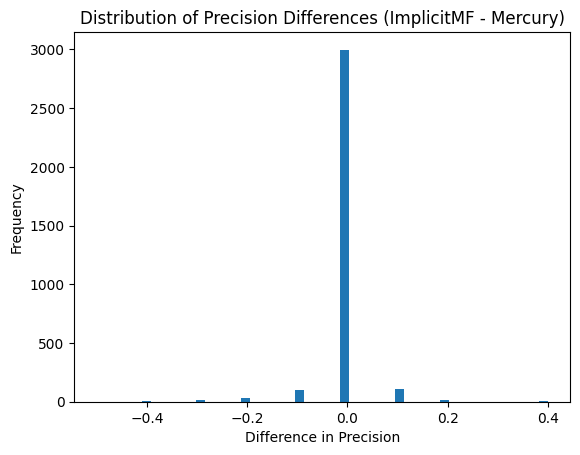

In [ ]:
differences = implicitfm_precision - mercury_precision
print("Summary of differences:")
print(f"Mean: {np.mean(differences)}, Std: {np.std(differences)}")

import matplotlib.pyplot as plt
plt.hist(differences, bins=50)
plt.title("Distribution of Precision Differences (ImplicitMF - Mercury)")
plt.xlabel("Difference in Precision")
plt.ylabel("Frequency")
plt.show()

In [ ]:
zero_both = ((implicitfm_precision == 0) & (mercury_precision == 0)).mean()
print(f"Percentage of users with zero precision for both models: {zero_both*100:.2f}%")

Percentage of users with zero precision for both models: 91.31%


In [ ]:
effect_size = (implicitfm_precision - mercury_precision).mean() / np.std(implicitfm_precision - mercury_precision)
print(f"Cohen's d effect size: {effect_size}")

Cohen's d effect size: -0.053967988487430486
